# Texas Bridge Data: Modelling Bridge Condition Based On Age, Usage, Material, Design

#### **Table of Contents**

1. **Section 1: Introduction**
  * Section 1.1: Outline


2. **Section 2: Data Cleaning**
  * Section 2.1: Understanding the variables provided
  * Section 2.2: Removing Missing Data
  * Section 2.3: Omitting irrelevant data from the dataset
  * Section 2.4: Gaining a more comprehensive view of the bridges' overall condition
      * Section 2.4.1: Score Rating
      * Section 2.4.2: Converting Year into Age
  * Section 2.5: Removing outliers based on Age and Historic data
      * Section 2.5.1: Age: Understanding the data through visualisation and statistics
      * Section 2.5.2: Historic: Understanding the data through visualisation and statistics
      * Section 2.5.3: Using Age and Historic data to spot outliers
      * Section 2.5.4: Omitting Old and Historic bridges
  * Section 2.6: Combining Categories  
  
  
3. **Section 3: Data Exploration**
  * Section 3.1: Preparing Data for Comparison
  * Section 3.2: Continuous Data
      * Section 3.2.1: Focusing on Age
          * Section 3.2.1.1: Age against Score
          * Section 3.2.1.2: Age against TrucksPercent
      * Section 3.2.2: Categorical Data Comparison
          * Section 3.2.2.1: Focusing on Material
          * Section 3.2.2.2: Focusing on Design
      * Section 3.3: Categorical Data Comparison
  * Section 3.3: Continuous and Categorical comparisons
  * Section 3.4: Preliminary Conclusions
  
  
4. **Section 4: Regression**
  * Section 4.1: Preparing the Data
  * Section 4.2: Regression Modelling
      * Section 4.2.1: Analysing Coefficients
      * Section 4.2.2: Analysing Error Distribution and RMSE value
      * Section 4.2.3: Using Regression to analyse the accuracy of the model
      
      
5. **Section 5: Conclusion**      

## 1. Introduction
### 1.1 Outline
This document uses the Texas Bridges dataset, and will focus specifically on using independant variables(predictors) to predict a dependant(target) variable using the following as predictor variables:
- Age of the bridge
- Average usage of the bridge
- Truck usage make-up in %
- Material used to construct the bridge
- Design of the bridge

The target variable will be the Condition Score, which is to be predicted by the independant / predictor variables listed above. This should give a rough idea as to how the bridge is doing indicating whether maintenance is required. To note, there are some degrees of inaccuracy to be expected as there are a lot more predictors that could affect the deterioration rate of a bridge which were not considered during this document. Other predictors include:
 - The grade of steel/ wood used
 - The composition / makeup of the concrete compound
 - The location of the bridge, i.e. if it goes over other streets, landscapes or over a river. Which may have an impact on the corrosion rate of metals, or the rotting rate of wood.
 - etc.

In [59]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
warnings.simplefilter(action='ignore', category=RuntimeWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('mode.chained_assignment', None)

## 2. Data Cleaning
### 2.1 Understanding the variables provided
 
Below are the default variables, as well as their attributes and what they define, found when importing the Texas bridges dataset.

| Variable      |      Description             | Type | 
|:--------------|:-----------------------------|:------:|
|Structure_id   | Unique identifier of the bridge                  | String |
|District       | Highway district in Texas responsible for bridge | category | 
|Detour_Km      | Length of detour if bridge closed                | continuous |
|Toll           | Whether a toll is paid to use bridge             | category |
|Maintainer     | The authority responsible for maintenance        | category |
|Urban          | Whether the bridge is located in an urban or rural area   | category |
|Status         | The road class: interstate to local                       | category | 
|Year           | The year the bridge was built                             | continuous | 
|Lanes_on       | The number of lanes that run over the bridge              | continuous (or discrete) |
|Lanes_under    | The number of lanes that run under the bridge             | continuous (or discrete) |
|AverageDaily   | The average daily traffic (number of vehicles)            | continuous |
|Future_traffic | The estimated daily traffic in approx 20 years time       | continuous |
|Trucks_percent | The percent of traffic made up of 'trucks' (i.e. lorries) | continuous |
|Historic       | Whether the bridge is historic                            | category | 
|Service_under  | The (most important) service that runs under the bridge   | category |
|Material       | The dominant material the bridge is made from             | category |
|Design         | The design of the bridge                                  | category |
|Spans          | The number of spans the bridge has                        | category (or discrete) |
|Length         | The length of the bridge in metres                        | continuous |
|Width          | The width of the bridge in metres                         | continuous |
|Rated_load     | The rated max loading of bridge (in tonnes)               | continuous |
|Scour_rating   | Only for bridges over water: the 'scour' condition        | ordinal |
|Deck_rating    | The condition of the deck of the bridge                   | ordinal |
|Superstr_rating| The condition of the bridge superstructure                | ordinal |
|Substr_rating  | The condition of the bridge substructure (foundations)    | ordinal |



#### The table below shows the data provided by the Texas Department of Transportation

In [60]:

# Creating the categorical data types, keeping them in order.

rating_type = pd.CategoricalDtype(
    categories=['Failed', 'Failing', 'Critical', 'Serious', 'Poor', 'Fair', 
                'Satisfactory', 'Good', 'Very Good', 'Excellent', 'NA'], 
    ordered=True)

types_dict = { 'Structure_id': str, 'District':'category', 'Toll':'category', 
              'Maintainer':'category', 'Urban':'category', 'Status':'category', 
              'Historic':'category', 'Service_under':'category', 'Trucks_percent':'int64', 'Material':'category', 
              'Design':'category', 
              'Deck_rating':rating_type, 'Superstr_rating':rating_type, 'Substr_rating':rating_type, 
              'Scour_rating':'category'}

df = pd.read_csv('tx19_bridges_sample.csv', dtype = types_dict, index_col = 'Structure_id')

df

,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,...,Spans,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic
Structure_id,,,,,,,,,,,,,,,,,,,,,
000021521-00101,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,2,31.4,4.3,Good,Very Good,Very Good,41.7,0,Dry,1
000021521-00181,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,1,15.5,4.3,Good,Good,Very Good,41.7,0,Dry,1
000021521-TMP20,District2,199,Free,Agency,Rural,Local,2012,2,0,100,...,1,10.1,8.4,Very Good,Very Good,Very Good,48.1,0,Dry,150
000021525-00012,District2,199,Free,Agency,Rural,Local,1950,1,0,80,...,14,45.4,3.7,Good,Good,Poor,10.0,0,Dry,120
000021580-00092,District2,6,Free,Agency,Rural,Local,2004,2,0,150,...,1,25.0,7.3,Good,Very Good,Very Good,37.2,4,Dry,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,District9,0,Free,Military,Urban,Local,1994,3,0,300,...,3,45.4,19.0,Good,Good,Good,64.3,40,No waterway,600
DAPFORHOO000013,District9,0,Free,Military,Urban,Local,2000,2,0,300,...,1,12.3,10.8,Good,Good,Good,35.1,40,No waterway,600
DAPFORHOO000015,District9,0,Free,Military,Urban,Minor,1996,2,7,1200,...,4,73.2,9.8,Good,Good,Good,24.5,25,No waterway,1500


As you can see, the data set includes a plethora of information, most of which are completely irrelevant in predicting the Condition Score of the bridge. For example, a bridge toll will not affect the condition or longevity of a bridge. The data set is currently broad and needs to be narrowed down to the columns we are actually interested in. I will do this over a few steps.

### 2.2 Removing Missing Data

to do this, I have listed below the amount of data we have for each variable in the dataset, what we want to look out for here is that all data equates to the same total. this dataset is supposed to have 34,293 values for each variables, which is displayed below the table output above. 

I have identified missing variables by checking and adding any null values in the dataset. If there is no missing values, the output should be 0 for all variables. here are the results:

In [3]:
#Adding up all null values in the dataframe
df.isnull().sum()

District           0
Detour_Km          0
Toll               0
Maintainer         0
Urban              0
Status             0
Year               0
Lanes_on           0
Lanes_under        0
AverageDaily       0
Historic           0
Service_under      0
Material           0
Design             0
Spans              0
Length             0
Width              0
Deck_rating        5
Superstr_rating    2
Substr_rating      0
Rated_load         0
Trucks_percent     0
Scour_rating       0
Future_traffic     0
dtype: int64

Missing data seems to be minimal relative to the size of the dataset, meaning that removing the missing data is appropriate in this scenario. If there were to be a sizeable portion of the data missing, then null values, where suitable, could have been replaced with a mean or median value taken from the dataset in attempt to fill the gaps.

The missing data has been removed, to check for this, we will again, look for any missing values in the data:

In [4]:
#dropping null values in the selected columns
df.dropna(subset = ['Deck_rating', 'Superstr_rating'], inplace=True)
df.isnull().sum()

District           0
Detour_Km          0
Toll               0
Maintainer         0
Urban              0
Status             0
Year               0
Lanes_on           0
Lanes_under        0
AverageDaily       0
Historic           0
Service_under      0
Material           0
Design             0
Spans              0
Length             0
Width              0
Deck_rating        0
Superstr_rating    0
Substr_rating      0
Rated_load         0
Trucks_percent     0
Scour_rating       0
Future_traffic     0
dtype: int64

### 2.3 Omitting irrelevant data from the dataset

Now that we have a complete dataset, we can start by removing variables that may not directly affect the condition of the bridge. 

The variables to be removed are:
 - District
 - Toll (Though this may make users of the bridge consider other options, this will not be a focus in this document)
 - Detour_km
 - Maintainer
 - Urban
 - Status
 - Lanes_on (Size could be a factor, but not part of the investigation)
 - Lanes_under
 - Spans
 - Length
 - Width
 - Rated load
 - Scour rating
 - Future traffic
 - Service under
 
#### Below is a table containing the remaining variables we are interested in.

In [5]:
#dropping un-neccessary columns in the dataframe and printing the head
df.drop(['District','Toll','Detour_Km','Maintainer','Urban','Status',
         'Lanes_on','Lanes_under','Spans','Length','Width','Rated_load',
         'Scour_rating','Future_traffic','Service_under'], axis = 1, inplace = True)

df.head()

,Year,AverageDaily,Historic,Material,Design,Deck_rating,Superstr_rating,Substr_rating,Trucks_percent
Structure_id,,,,,,,,,
000021521-00101,2005,1,Not historic,Concrete,Slab,Good,Very Good,Very Good,0
000021521-00181,2005,1,Not historic,Concrete,Slab,Good,Good,Very Good,0
000021521-TMP20,2012,100,Not historic,Concrete,Beam,Very Good,Very Good,Very Good,0
000021525-00012,1950,80,Not historic,Timber,Beam,Good,Good,Poor,0
000021580-00092,2004,150,Not historic,Concrete,Beam,Good,Very Good,Very Good,4


### 2.4 Gaining a more comprehensive view of the bridges' overall condition
#### 2.4.1 Score Rating

Now that most excess data has been removed, we can can see a clearer picture of what is going on. More specifically the year the bridge was built in, the average number of visitors and how that relates to the ratings given to the bridge.

To make this dataset clearer, I will be combining the scores for an overall score of the bridge under variable name ConditionScore. this will be done as follows:
 - Ratings have a common categorical evaluation, i.e. they share the same grading system, so I will be converting the scores given, e.g. Good, Excellent etc to a numeric rating from 0 - 9 (based on the number of categories there currently are).
 - Ratings will then be added up from all 3 categories to give the bridge a Condition Score score out of 27.
 
Below is the result:

In [6]:
#Creating a rating score system, which takes each category and turns it into a numeric
rating_score = {'Excellent' : 9, 'Very Good' : 8, 'Good' : 7, 'Fair' : 6, 'Satisfactory' : 5, 'Poor' : 4, 'Serious' : 3, 'Critical' : 2, 'Failing' : 1, 'Failed' : 0}

#mapping the rating system to the variables that need it, also converting the type to int to get rid of decimals
df['Deck_rating'] = df['Deck_rating'].map(rating_score).astype('int64')
df['Superstr_rating'] = df['Superstr_rating'].map(rating_score).astype('int64')
df['Substr_rating'] = df['Substr_rating'].map(rating_score).astype('int64')

#creating a new column, 'ConditionScore' which takes the sum of the 3 ratings.
current_cond = df.Deck_rating + df.Superstr_rating + df.Substr_rating
df = df.assign(ConditionScore = current_cond)
df

,Year,AverageDaily,Historic,Material,Design,Deck_rating,Superstr_rating,Substr_rating,Trucks_percent,ConditionScore
Structure_id,,,,,,,,,,
000021521-00101,2005,1,Not historic,Concrete,Slab,7,8,8,0,23
000021521-00181,2005,1,Not historic,Concrete,Slab,7,7,8,0,22
000021521-TMP20,2012,100,Not historic,Concrete,Beam,8,8,8,0,24
000021525-00012,1950,80,Not historic,Timber,Beam,7,7,4,0,18
000021580-00092,2004,150,Not historic,Concrete,Beam,7,8,8,4,23
...,...,...,...,...,...,...,...,...,...,...
DAPFORHOO000012,1994,300,Not historic,Concrete,Beam,7,7,7,40,21
DAPFORHOO000013,2000,300,Not historic,Concrete,Beam,7,7,7,40,21
DAPFORHOO000015,1996,1200,Not historic,Concrete,Beam,7,7,7,25,21


Now that we have an overall rating summarised in Condition Score, we will be using that as our target variable and thus, will no longer need the individual ratings. To keep the table clean and easy to read, the following variables will be removed:
 - Deck_rating
 - Superstr_rating
 - Substr_rating

In [7]:
#dropping the 3 columns since we no longer need them
df.drop(['Deck_rating', 'Superstr_rating', 'Substr_rating'], axis = 1, inplace = True)

#### 2.4.2 Converting Year into Age

Though the year in which a particular bridge was built is useful, it would be better to convert it to an Age variable as it makes it easier to work with, visualise and understand. so each Year value will be subtracted from the current year (2021 as of the creation of this document) and will be added under a new variable named 'Age'.

Below are the results:

In [8]:
#calculating age from the year variable and adding it to the dataframe
age = 2021 - df.Year
df = df.assign(Age = age)
df

,Year,AverageDaily,Historic,Material,Design,Trucks_percent,ConditionScore,Age
Structure_id,,,,,,,,
000021521-00101,2005,1,Not historic,Concrete,Slab,0,23,16
000021521-00181,2005,1,Not historic,Concrete,Slab,0,22,16
000021521-TMP20,2012,100,Not historic,Concrete,Beam,0,24,9
000021525-00012,1950,80,Not historic,Timber,Beam,0,18,71
000021580-00092,2004,150,Not historic,Concrete,Beam,4,23,17
...,...,...,...,...,...,...,...,...
DAPFORHOO000012,1994,300,Not historic,Concrete,Beam,40,21,27
DAPFORHOO000013,2000,300,Not historic,Concrete,Beam,40,21,21
DAPFORHOO000015,1996,1200,Not historic,Concrete,Beam,25,21,25


Again, we do not need data which portrays the same information in different ways, thus I will be taking out the Year variable. Some slight renaming and re-ordering of the variables will also occur in this stage to improve legibility of the data.

The target variable will be moved to the right hand side, and age will be the first column in the table. Underscores will be removed and replaced with CamelCase variables to maintain consistancy. Below are the results:

In [9]:
#dropping year variable
df.drop(['Year'], axis = 1, inplace = True)

#renaming truckspercent, renaming structure id, then reordering the dataframe for easier legibility
df.rename(columns = {'Trucks_percent':'TrucksPercent'}, inplace = True)
df.index.names = ['StructureID']

df = df[['Age', 'Material', 'Design', 'Historic', 'AverageDaily', 'TrucksPercent', 'ConditionScore']]
df

,Age,Material,Design,Historic,AverageDaily,TrucksPercent,ConditionScore
StructureID,,,,,,,
000021521-00101,16,Concrete,Slab,Not historic,1,0,23
000021521-00181,16,Concrete,Slab,Not historic,1,0,22
000021521-TMP20,9,Concrete,Beam,Not historic,100,0,24
000021525-00012,71,Timber,Beam,Not historic,80,0,18
000021580-00092,17,Concrete,Beam,Not historic,150,4,23
...,...,...,...,...,...,...,...
DAPFORHOO000012,27,Concrete,Beam,Not historic,300,40,21
DAPFORHOO000013,21,Concrete,Beam,Not historic,300,40,21
DAPFORHOO000015,25,Concrete,Beam,Not historic,1200,25,21


#### The dataset above has the following columns:

 - `StructureID`: Representing the state-issued unique identifiers of each of the bridges.
 - `Age`: Representing how old a bridge is.
 - `Material`: Representing the Material used to construct a bridge.
 - `Design`: Representing the Design used to construct a bridge.
 - `Historic`: Indicates whether a bridge is of any historic value to the state.
 - `DailyAverage`: Representing the average daily usage of a bridge.
 - `TrucksPercent`: Representing the proportion of trucks(in %) using a particular bridge from the daily average.
 - `ConditionScore`: A score given to a bridge out of 27, based on the overall rating of a bridge.

### 2.5 Removing outliers based on Age and Historic data

In this section and as part of the cleaning process, outliers will be removed as specified in the brief issued based on the age of the bridge as well as the historic data provided. I will be using a combination of both Age and Historic data to identify outliers and find out what the best way is to deal with the current data provided.

#### 2.5.1 Age: Understanding the data through visualisation and statistics

Firstly, with a primary focus on age, a density plot in conjunction with a box plot  are displayed to locate outliers and understand the statistics of the information provided.

In [2]:
#creating the figure, setting the size
fig, ax = plt.subplots(figsize = (14,6))

#plotting a distribution using seaborn libraries showing the density of age results, changing the colour to green to match an ongoing theme
sns.distplot(df['Age'], color = 'cornflowerblue')

#plotting the mean line
plt.axvline(x = np.mean(df['Age']), c = 'red', ls = '-.', label = 'Mean')

#plotting the upper and lower quartiles
plt.axvline(x = np.percentile(df['Age'], 25), c = 'black', ls = ':', label = '25th to 75th percentile')
plt.axvline(x = np.percentile(df['Age'], 75), c = 'black', ls = ':')

#plotting titles and the legend, then setting the x limits to keep the plot concise
plt.title('Distribution of Age data', fontsize = 20)
plt.legend()
plt.xlim(0,130);

NameError: name 'plt' is not defined

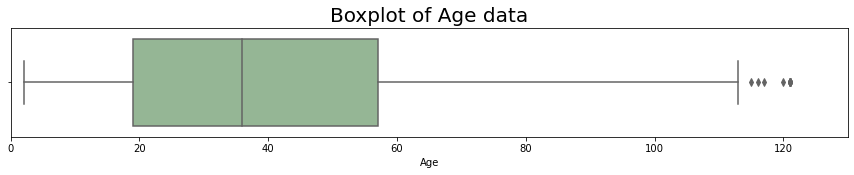

In [11]:
# creating a figure and plotting a seaborn boxplot of age distribution
fig, ax = plt.subplots(figsize=(15,2))
ax = sns.boxplot(x='Age', data = df, color='darkseagreen', ax = ax).set(xlim=(0,130))
plt.title('Boxplot of Age data', fontsize = 20);

#### Statistics on Age variable

In [12]:
#describing age statistically
df['Age'].describe()

count    34286.000000
mean        39.502917
std         23.860336
min          2.000000
25%         19.000000
50%         36.000000
75%         57.000000
max        121.000000
Name: Age, dtype: float64

#### What can we say from the visualisations and statistical analysis?

Here are my observations:
 - The data at first glance seems to have a high range, spanning over 119 years. The standard deviation is 23.9 which is quite high. Though the standard deviation is based on the distance from the mean, I believe it correlates with my observation of vast range in the dataset.
 - The data seems to really tail off at around 80 years of age and up, which leads me to believe that other factors such as whether the bridges are historic or not come into play. 
 - When looking at the statistical information on Age as well as the box plot, it is clear to see the maximum value is also very distant from the upper quartile, indicating a strong positive skew, the tail on the box plot is long with some outliers present.
 - Most bridges seem to be of age 15 - 60 years of age, with the interquartile range being 38 years (between 19 and 57), in which both the median (36 years) and the mean (39.5 years) of the data lie.
 - The boxplot shows outliers from around 112 years of age and above which need to be omitted.
 
Before analysing historical data, here are my initial thoughts on actions to take upon my observation:
 - It would be fair to assume that any value above the Age of 80 would not be greatly indicative of the rest of the dataset, as that is where the density seems to strongly decline in our distribution plot.
 - Removing data recorded on bridges of Age 80 and Above also means that outliers will be removed in the process.
 
Unless Historic data conflicts with the observations made, this will be my course of action. 

#### 2.5.2 Historic: Understanding the data through visualisation and statistics

rather than looking at Historic bridges individually, I will compare compare the data provided with the Age findings. This will allow me to understand the relationship between the Historic and Age variables, allowing for quicker conclusions to be drawn if a pattern is observed.

Again, I will be utilising a Density plot to visualise Historic data. Since Historic data is provided in categories, I will be using Age as the axis, and looking at particularly the 'Register' category to understand where registered historic bridges lie in relation to Age.

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


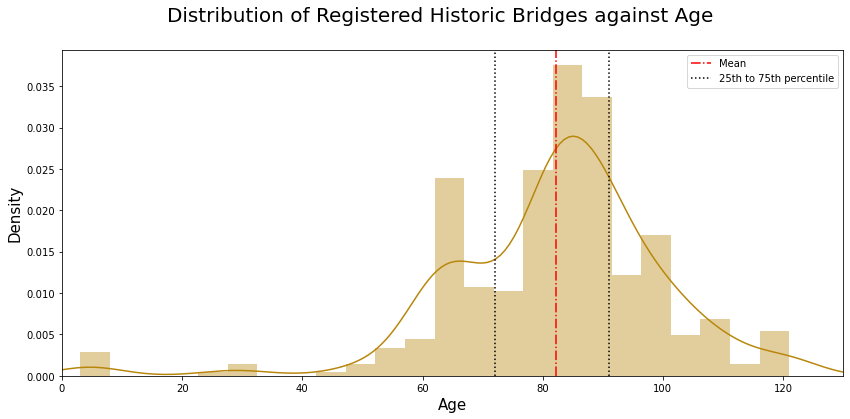

In [13]:
#grouping by history and obtaining the register category
h1 = df.groupby(by = 'Historic', dropna = True)
register_dist = h1.get_group('Register')

fig, ax = plt.subplots(figsize = (14,6))

#plotting age against the register category to gain better understanding of where registered bridges lie in relation to age
sns.distplot(register_dist['Age'], color = 'darkgoldenrod')

#again plotting mean and quartiles
plt.axvline(x = np.mean(register_dist['Age']), c = 'red', ls = '-.', label = 'Mean')
plt.axvline(x = np.percentile(register_dist['Age'], 25), c = 'black', ls = ':', label = '25th to 75th percentile')
plt.axvline(x = np.percentile(register_dist['Age'], 75), c = 'black', ls = ':')
#legend and annotations
plt.legend()
plt.xlim(0,130)
plt.ylabel('Density', fontsize = 15)
plt.xlabel('Age', fontsize = 15)
plt.suptitle('Distribution of Registered Historic Bridges against Age', fontsize = 20)
plt.title('');

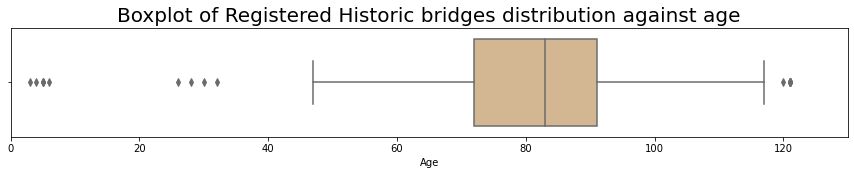

In [14]:
#plotting boxplot for historic
fig, ax = plt.subplots(figsize=(15,2))
ax = sns.boxplot(x='Age', data = register_dist, color='burlywood', ax = ax).set(xlim=(0,130))
plt.title('Boxplot of Registered Historic bridges distribution against age', fontsize = 20);

#### Statistics on Registered historic bridges in relation to the Age variable

In [15]:
register_dist['Age'].describe()

count    417.000000
mean      82.206235
std       18.186154
min        3.000000
25%       72.000000
50%       83.000000
75%       91.000000
max      121.000000
Name: Age, dtype: float64

#### 2.5.3 Using Age and Historic data to spot outliers
#### What can we say from these results?
As can be seen from the visualisations alongside the statistics above, it is clear to see that as bridges get older, they are more likely to be registered as historic. Here is just a list of a few observations I found when comparing the 'Register' category from the Historic variable with 'Age':
 - The density plot indicates a negative skew to the data, which means as stated above, the older the bridge, the more likely it is to be registered as historic, which makes sense.
 - We also observe the mean and the median from the box plot and the density plot to be greater than 80 years old, which falls in line with our analysis carried out in section 2.5.1.
 - There are some outliers where newer bridges have been marked as historic, and extremely old bridges are are marked as historic. I believe the older bridges may not be outliers, however, there isnt enough data provided on age ranges beyond 121 to help with the analysis the box plot provides. 
 - the standard deviation is 18.2 which means the data is relatively distributed.
 
#### 2.5.4 Omitting Old and Historic bridges

Firstly, starting with Age, I will look at the amount of data points which fall above 80 years of age, just to make sure data is not excessively removed or greatly decreases the amount of data we have to analyse.

#### No. of bridges over 80 years old:

In [16]:
#looking at the number of datapoints over age of 80
#making sure I dont delete too much data
df1 = df[df.Age > 80]
df1['Age'].count()

2521

There are only 2,521 data points which fall above 80 years of age, which is a small amount relative to a 34000 row dataset, next I will look at the amount of Registered historic bridges, again to double check I am not wiping a sizeable proportion of the dataset.

#### No. of bridges in each of the Historic categories:

In [17]:
df['Historic'].value_counts()

Not historic    19908
Possible        13903
Register          417
Unknown            58
Name: Historic, dtype: int64

It seems Register only has 417 datapoints associated so it will be omitted. 

Alongside registered bridges, I will also remove unknown Historic categories to reduce randomness and anomalies in the data. Since 'Unknown' means data is not provided, it acts almost as a null value and should be removed. Below is a print out of what is left of the Historic categories. As you can see, the Unknown and Registered historic bridges have now been omitted leaving us with only 'Not Historic' and 'Possible' historic bridges, which are all under 80 years of age.

#### Categories we are left with from the Historic variable:

In [18]:
#creating a new dataframe which only looks at values below 80 years old
df = df[df.Age < 80]

#new categories, dropping unknown and registered bridges
filter_non_historic_bridges = {'Not historic' : 'Not historic', 'Possible' : 'Possible'}
df.Historic = df['Historic'].map(filter_non_historic_bridges).astype('category')
df.dropna(subset = ['Historic'], inplace=True)

#displaying the numbers to double check the categories were dropped
df['Historic'].value_counts()

Not historic    19901
Possible        11605
Name: Historic, dtype: int64

Now that the filtering process is complete, we can remove the Historic variable from our data, leaving us with only our 5 predictors and our target variable.

#### Data table with omitted 'Historic' variable:

In [19]:
#dropping historic column
df.drop('Historic', axis = 1, inplace = True)
df

,Age,Material,Design,AverageDaily,TrucksPercent,ConditionScore
StructureID,,,,,,
000021521-00101,16,Concrete,Slab,1,0,23
000021521-00181,16,Concrete,Slab,1,0,22
000021521-TMP20,9,Concrete,Beam,100,0,24
000021525-00012,71,Timber,Beam,80,0,18
000021580-00092,17,Concrete,Beam,150,4,23
...,...,...,...,...,...,...
DAPFORHOO000012,27,Concrete,Beam,300,40,21
DAPFORHOO000013,21,Concrete,Beam,300,40,21
DAPFORHOO000015,25,Concrete,Beam,1200,25,21


## 2.6 Combining Categories

In this section, the focus is combining categories in the categorical variables (Material and Design) as per brief requirement. I will look at the number of bridges using particular designs/ materials. If there are underused categories, I will combine them with the 'Other' category as there is no need for such categories to remain in the data we work with. It would make comparisons take longer and is inefficient. This data will only represent a very small proportion of the dataset so it is best that the categories are combined.

Below are materials/ designs used, the bar chart shows the number of bridges using each material/ design such that the scale is comparable amongst categories within a variable.

### Bar charts showing popularity of each material / design

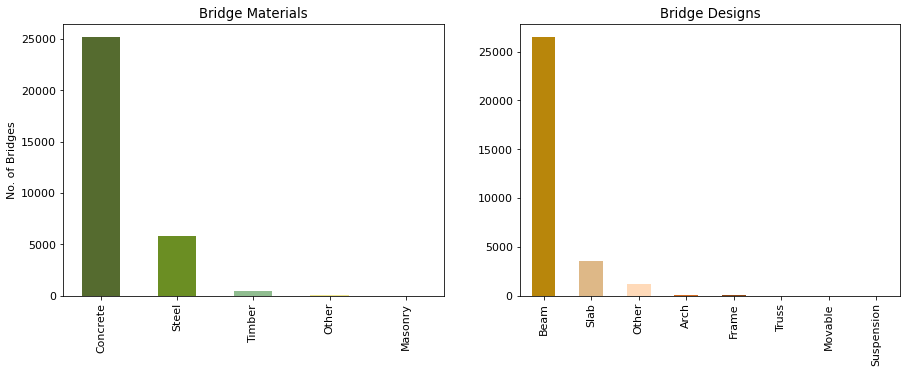

In [20]:
plt.figure(figsize = (15,5))

#creating a colourscheme for the document
palette1 = ['darkolivegreen', 'olivedrab', 'darkseagreen', 'khaki', 'darkkhaki', 'olive']
palette2 = ['darkgoldenrod', 'burlywood', 'peachpuff', 'chocolate', 'saddlebrown', 'peru', ]

plt.rcParams.update({'font.size': 11})

#plotting bar charts for material and design counts
plt.subplot(1,2,1);df.Material.value_counts().plot(kind='bar', color = palette1);plt.title('Bridge Materials')
plt.ylabel('No. of Bridges')

plt.subplot(1,2,2);df.Design.value_counts().plot(kind='bar', color = palette2);plt.title('Bridge Designs');


### Material usage distribution

In [21]:
#looking at the numbers accurately
df['Material'].value_counts()

Concrete    25221
Steel        5792
Timber        449
Other          42
Masonry         2
Name: Material, dtype: int64

### Design usage distribution

In [22]:
df['Design'].value_counts()

Beam          26515
Slab           3602
Other          1212
Arch            100
Frame            52
Truss            14
Movable           8
Suspension        3
Name: Design, dtype: int64

Looking at the Material Distribution:
 - Masonry is only used by 2 bridges.
 - Timber usage is comparatively in relation to Concrete and Steel.
 
Based on my findings, I will be merging Timber, Masonry into the  Other such that they can collectively represent a more substantial proportion of the dataset.

### Combined Material Categories

In [23]:
#reducing number of categories in material
grouping_materials = {'Concrete':'Concrete', 'Steel':'Steel', 'Timber':'Other', 
          'Other':'Other', 'Masonry':'Other'}

df.Material = df.loc[:,'Material'].map(grouping_materials).astype('category')

df.loc[:,'Material'].value_counts()

Concrete    25221
Steel        5792
Other         493
Name: Material, dtype: int64

Looking at the Design Distribution:
 - Moveable, Truss and Suspension designs are only used by 25 bridges in total.
 - Frame and Arch designs are comparatively low in relation to Beam and Slab designs.
 
Based on my findings, I will be merging Moveable, Truss, Suspension, Frame and Arch designs into the other category such that they represent a more substantial proportion of the dataset.

### Combined Design Categories

In [24]:
#reducing number of categories in design
grouping_design = {'Beam':'Beam', 'Slab':'Slab', 'Other':'Other', 
          'Arch':'Other', 'Truss':'Other', 'Frame':'Other', 'Movable':'Other', 'Suspension':'Other'}

df.loc[:,'Design'] = df.loc[:,'Design'].map(grouping_design).astype('category')

df.loc[:,'Design'].value_counts()

Beam     26515
Slab      3602
Other     1389
Name: Design, dtype: int64

### Plotted Material / Design Categories

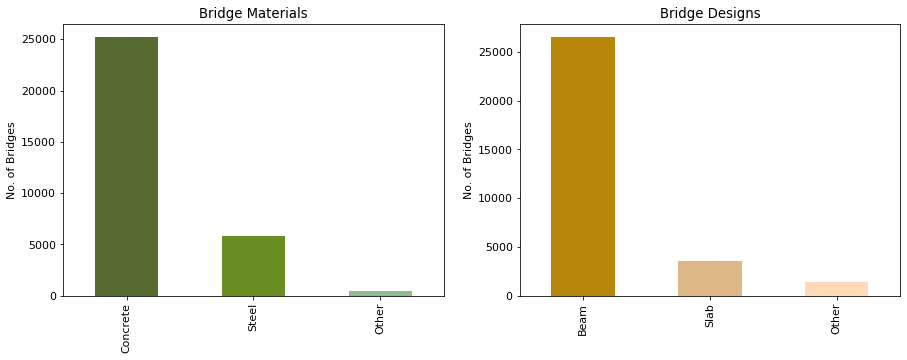

In [25]:
#plotting material and design after category reduction
plt.figure(figsize = (15,5))

plt.rcParams.update({'font.size': 11})

plt.subplot(1,2,1);df.Material.value_counts().plot(kind='bar', color = palette1);plt.title('Bridge Materials')
plt.ylabel('No. of Bridges')

plt.subplot(1,2,2);df.Design.value_counts().plot(kind='bar', color = palette2);plt.title('Bridge Designs')
plt.ylabel('No. of Bridges');

# 3. Exploring Data

## 3.1 Preparing Data for Comparison

Before we start this section and to make things easier, I will be using the combined Current Conditions stored under the variable 'ConditionScore' to split them back up into categories under a new variable named 'CurrentCondition'. This will increase the versatility of the scores, allowing for more ways to compare and contrast the relationships through more visualisations.

The way I have gone about this is dividing them into 4 categories, which use the previous categories as a reference for score.

for example, Previously where a 'good' score was allocated 7 points, an overall 'Excellent to Good' bridge would be the sum of 3 good scores (7 + 7 + 7) which equal 21. 

This means that:
 - Any bridge that has a score of 22 or more will be placed in the category 'Excellent to Good'
 - Any bridge that has a score which lies between (and including) 16 and 21 will be placed in category 'Good to Satisfactory'
 - Any bridge that has a score which lies between (and including) 10 and 15 will be placed in category 'Satisfactory to Serious'
 - Any bridge that has a score which lies between (and including) 9 or less will be placed in category 'Serious or Worse'
 
This way, Allocated ratings can stay true to the original scores.

#### Preview of new variable 'CurrentCondition'

In [26]:

#creating categories out of the ConditionScore
rating_dict = {}

for i in range(len(df)):
    if df['ConditionScore'][i] > 21 :
        rating = {df.index[i] : 'Excellent to Good'}
        rating_dict.update(rating)
    elif df['ConditionScore'][i] > 15 & df['ConditionScore'][i] <= 21:
        rating = {df.index[i] : 'Good to Satisfactory'}
        rating_dict.update(rating)
    elif df['ConditionScore'][i] > 9 & df['ConditionScore'][i] <= 15 :
        rating = {df.index[i] : 'Satisfactory to Serious'}
        rating_dict.update(rating)
    else:
        rating = {df.index[i] : 'Serious or Worse'}
        rating_dict.update(rating)

#assigning the new condition categories to the dataframe        
df = df.assign(CurrentCondition = rating_dict.values())

df.head(5)

,Age,Material,Design,AverageDaily,TrucksPercent,ConditionScore,CurrentCondition
StructureID,,,,,,,
000021521-00101,16,Concrete,Slab,1,0,23,Excellent to Good
000021521-00181,16,Concrete,Slab,1,0,22,Excellent to Good
000021521-TMP20,9,Concrete,Beam,100,0,24,Excellent to Good
000021525-00012,71,Other,Beam,80,0,18,Good to Satisfactory
000021580-00092,17,Concrete,Beam,150,4,23,Excellent to Good


## 3.2 Continuous Variables

Now that the data has been cleaned, we can reliably and accurately compare predictor variables against the target variable as well as against each other to identify underlying paterns.

Starting off with comparing all the Continuous Variables in the data, a heat map will be used to identify possible relationships. This will be used as a starting point to identify the continuous variables which may have the greatest influence on the target variable.

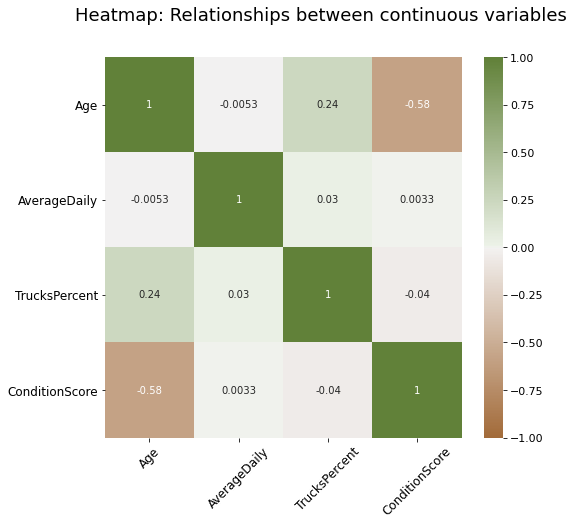

In [27]:
#plotting a heatmap to show relationship between continuous variables
fig,ax = plt.subplots(figsize=(8,7))
sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(40, 110, as_cmap=True), 
            annot=True, ax=ax, annot_kws={"size": 10})
plt.yticks(rotation=0, fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.suptitle('Heatmap: Relationships between continuous variables', fontsize = 18);

### What does the heat map tell us?

The heatmap describes the relationship between variables through values between -1 and 1. It is a measure of correlation where -1 is a very strong negative correlation, and 1 is a strong positive correlation. 0 tells us there is little to no pattern to be seen between two variables.

taking that into considerations, here is what we can say:
 - There is strong negative correlation between the Condition Score and the age variables, which means that the older a bridge gets, the worse the condition becomes.
 - there is some positive correlation between the percentage of trucks and age variable where the newer a bridge is, the greater the percentage of trucks using it is.
 - the rest of the data falls within very close proximity of 0, which means there is very little to no correlation between:
     - Average Daily and Age
     - Average Daily and Condition Score
     - Trucks Percent and Daily Average
     - Trucks Percent and Condition Score

Now that we have the basis of our continous variables analysis, we can further explore the variables which correlate as they are more likely to reveal underlying patterns in the data.

During section 3, I will further look into:
 - The correlation between Age and Condition.
 - the correlation between Trucks Percent and Age.
 - Categorical variables against the other predictors and the target variable

### 3.2.1 Focusing on Age
#### 3.2.1.1 Age against Score

In the heatmap, section 3.2, there was a strong negative correlation between the Current Condition and the Age. Here I have created a box plot utilisng the categories we created from the Condition Score scores in part 3.1 to visualise the relationship between the two variables. Below are the results:

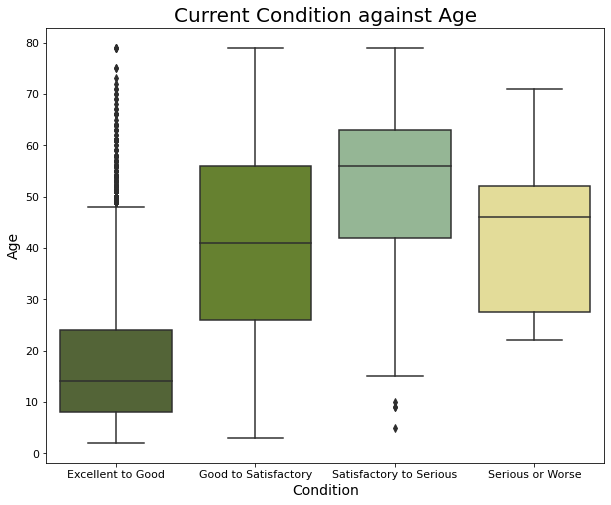

In [28]:
#plotting box plots of condition against age
fig, ax = plt.subplots(1, 1, figsize=(10,8))
sns.boxplot(x = df.CurrentCondition, y = df.Age, ax = ax, palette = palette1);
plt.title('Current Condition against Age', fontsize = 20)
plt.suptitle('')
plt.ylabel('Age', fontsize = 14)
plt.xlabel('Condition', fontsize = 14);

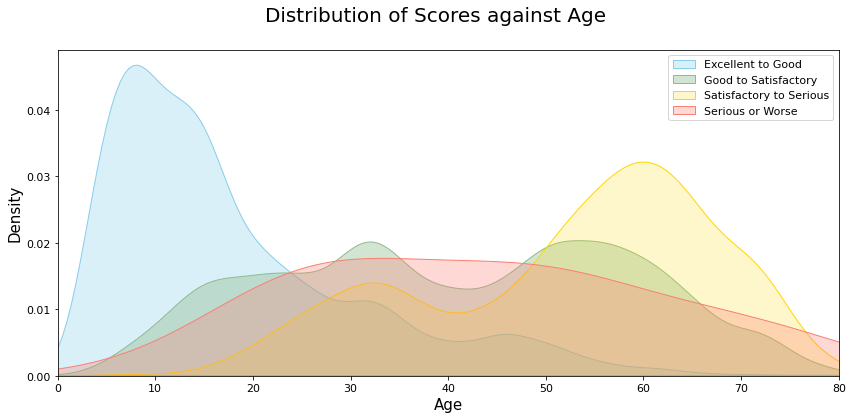

In [29]:
#grouping Current Condition, then assigning variables to each of the categories for easier referencing for plot
score = df.groupby(by = 'CurrentCondition', dropna = True)
excellent_to_good = score.get_group('Excellent to Good')
good_to_satisfactory = score.get_group('Good to Satisfactory')
satisfactory_to_serious = score.get_group('Satisfactory to Serious')
serious_or_worse = score.get_group('Serious or Worse')

fig, ax = plt.subplots(figsize = (14,6))
var = 'Age'

#plotting a kde to show the relationships between categories against age

sns.kdeplot(data=excellent_to_good[var], label='Excellent to Good', ax=ax, alpha=0.3, shade=True, color = 'skyblue')
sns.kdeplot(data=good_to_satisfactory[var], label='Good to Satisfactory', ax=ax, alpha=0.4, shade=True, color = 'darkseagreen')
sns.kdeplot(data=satisfactory_to_serious[var], label='Satisfactory to Serious', ax=ax, alpha=0.2, shade=True, color = 'gold')
sns.kdeplot(data=serious_or_worse[var], label='Serious or Worse', ax=ax, alpha=0.3, shade=True, color = 'salmon')

#labels and legend
plt.legend()
plt.xlim(0,80)
plt.ylabel('Density', fontsize = 15)
plt.xlabel('Age', fontsize = 15)
plt.suptitle('Distribution of Scores against Age', fontsize = 20)
plt.title('');

### What do the visualisations tell us?

#### Box plots:
 - There seems to be a general trend where the median of the scores seems to corrolate with the age where generally: The newer a bridge is (Low Age), the better its condition is.
 - Judging solely by the box plot, you can already tell that the 'Good to Excellent' score has a strong positive skew but has many outliers. This indicates that most the results reside between its interquartile range, and the data has a long tail.
 - The pattern seems pretty strong, as the median of the 'Good to Excellent' score lies at about 14 years, the median of Good to Satisfactory lies at around 41 years and the median of 'Satisfactory to Serious' lies at around 56 years.
 - The only anomaly to be seen in the boxplot is the median score of the 'Serious or Worse' conditional rating. I believe this particular Current Condition may be affected by other factors than age hence the lack of corrolation with the rest of the results, though the minimum age it got at around 22 years is still considerably higher than that of the other scores.
 
#### Kernel Density Estimate (KDE) Plot:
 - The most apparent connection I see between age and the Current Condition is that typically, the newer the bridge the less likely it is to fail or have any issues. comparing this KDE with the boxplot, the KDE explains the outliers found for 'Excellent to Good' as the data for that particular category seems to tail off pretty dramatically.
 - The second strongest pattern to spot is the 'Satisfactory to Serious' plot which shows a strong negative skew, again correlating with our analogy, meaning the older a bridge is, the more prone it is to have issues and eventually fail.
 - The KDE doesnt quite portray the other 2 categories very well as they seem fairly evenly distributed, which is why the boxplots were used to help understand the patterns. 
 
Overall, it is clear to see that there is strong correlation between the Age variable and the CurrentCondition derived from the ConditionScore variable.

#### 3.2.1.2 Age against TrucksPercent

Through the Heatmap diagram (Section 3.2), there various variables which did not correlate with each other thus there is no need for further exploration through further comparisons and analytics. However, we did see some slight correlation between the Age variable and the Trucks Percent variable which I will be exploring further below.

Again, I will be using a KDE plot to understand the relationship between the two variables. I initially tried using a scatter plot, however due to the large dataset and minimal correlation, little to no patterns were obvious to spot at first glance. 

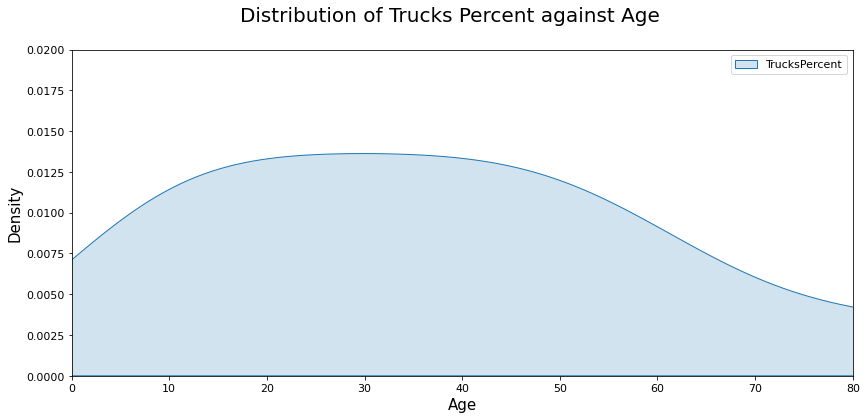

In [30]:
gByTrucks = df.groupby(by = 'TrucksPercent', dropna = True)

fig, ax = plt.subplots(figsize = (14,6))

#plotting a kde to look at the distribution of truckspercent against age
sns.kdeplot(data = gByTrucks[var], label='TrucksPercent', ax=ax, alpha=0.2, shade=True)
plt.legend()
plt.xlim(0,80)
plt.ylim(0, 0.02)
plt.ylabel('Density', fontsize = 15)
plt.xlabel('Age', fontsize = 15)
plt.suptitle('Distribution of Trucks Percent against Age', fontsize = 20)
plt.title('');

From this plot, we can see a slight positive skew, however a generally even which indicates a greater density of Trucks percent on Newer bridges comparative to older bridges. This means that generally (though not by a significant amount), we could say from these results that daily usage of newer bridges may consist of a higher proportion of trucks (in %) than older ones.

### 3.2.2 Categorical Data Comparison
#### 3.2.2.1 Focusing on Material

Focusing on categorical data, a good starting point would be to compare them with other categorical data. Starting off this analysis, I just wanted to show the number of bridges using each material to take that into consideration when looking at the analysis. It is important to note that Concrete is by far the most commonly used material in bridges so keep that in mind.

In [31]:
df['Material'].value_counts()

Concrete    25221
Steel        5792
Other         493
Name: Material, dtype: int64

I have used Pie Charts to show the distribution of scores within each material below.

#### Pie Charts for Materials used showing proportion of CurrentCondition categories:

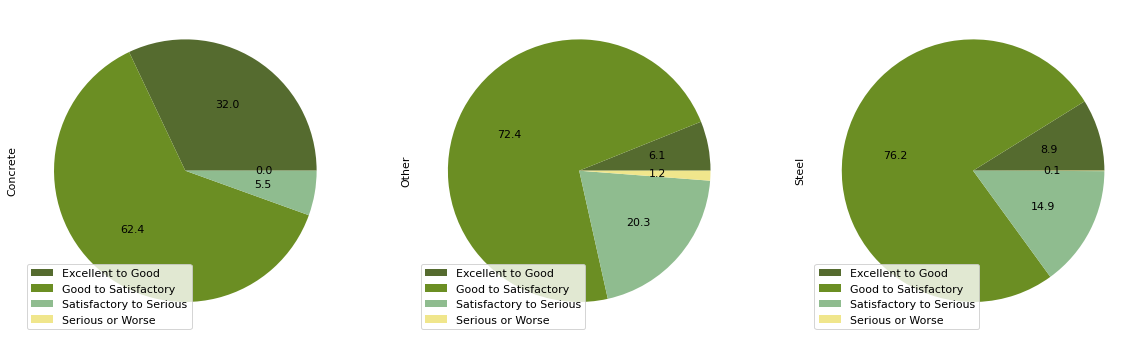

In [32]:
#pie charts showing the material given the condition. each material treated as a whole (1)
cond_and_mat = pd.crosstab(df.CurrentCondition, [df.Material], normalize=False)
a1,a2,a3 = cond_and_mat.plot(kind='pie', subplots=True, figsize=(20,20), autopct='%.1f', colors = palette1, labeldistance = None)
a1.legend(loc = 3)
a2.legend(loc = 3)
a3.legend(loc = 3);

we can tell the following from the Pie Charts:
 - All 3 materials seem to score satisfactory or above in their overall condition, with the least being at a combined 76% chance that the condition of a bridge given its material is of score Satisfactory or above.
 - Concrete seems to best overall, where 32% of bridges made of Concrete are in 'Excellent to Good' condition. The combined rating from Satisfactory to excellent makes up 94.4% of its score, meaning that if you were to look at any Concrete bridge in texas, there is a 94.4% chance that it is of score Satisfactory or above.
 - If you were to choose any given bridge of 'Other' material, the probability of it being of score satisfactory or worse is 20%, which is the highest of the 3 materials, with steel not being far off at 14.9%
 
Generally speaking, Concrete seems to be the best overall material in terms of score, followed by Steel then other being the worst.

Below I have visualised the data, showing the probability of a materials score given the materal as well as the probability of the condition given the material used.

#### Probability Bar Charts 

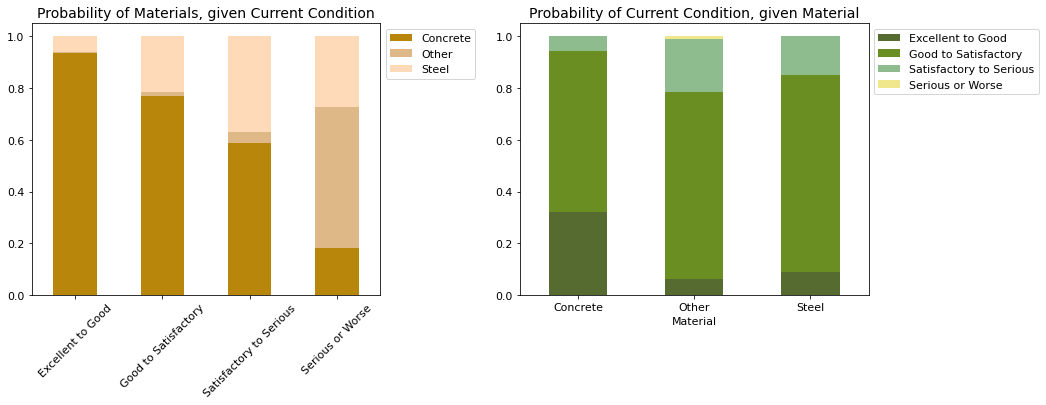

In [33]:

# cross tabulating more probabilities
mat_given_cond = pd.crosstab(df.CurrentCondition, [df.Material], normalize='index')
cond_given_mat = pd.crosstab(df.Material, [df.CurrentCondition], normalize='index')

cond_and_mat = pd.crosstab(df.CurrentCondition, [df.Material], normalize='all')
mat_and_cond = pd.crosstab(df.Material, [df.CurrentCondition], normalize='all')




fig, (a1, a2) = plt.subplots(1, 2, figsize=(15,5))
fig.subplots_adjust(wspace=0.4)

#plotting the cross tabs, labels are rotated to avoid label overlap. also legend is off to the side to avoid blocking data
mat_given_cond.plot(kind = 'bar', subplots=False, ax = a1, rot = 45, stacked = True, color = palette2)
a1.set_title('Probability of Materials, given Current Condition', fontsize=14)
a1.set_xlabel('')
a1.legend(bbox_to_anchor=(1, 1))

cond_given_mat.plot(kind = 'bar', subplots = False, ax = a2, rot = 0, stacked = True, color = palette1)
a2.set_title('Probability of Current Condition, given Material', fontsize=14)
a2.legend(bbox_to_anchor=(1, 1));

First looking at the Probability of Material, given the Condition Score score, we can see that:
 - Concrete is the most popular in 3 of the score categories, This is primarily due to the amount of bridges which utilise concrete construction. It is important to take this information into account, though in this case, concrete is also the best. 
 - It seems as though despite how little bridges utilise 'Other' materials, most 'Other' materials reside in the category 'Serious or Worse', making up over 0.5 probability of the 'serious or worse' category.
 - Concrete, despite its shear amount, only makes up about 0.2 probability of it being a condition 'Serious or Worse'.
 - Since there is less Concrete in the 'Satisfactory to Serious' category, there is a greater chance that if a bridge was picked at random, it would be made of steel.
 
Now looking at the probability of the condition, given the material used, which visualises the same information as the pie charts, however, the proportions are easier to compare here between the materials. Here, it is evem clearer to see that the overall rating of Concrete is better than that of both steel and other. Where the 'Other' materials seem to perform the worse. It is the only material in which you can see the 'Serious or Worse' category in the visualisation.

To further reinforce my analysis, a boxplot has been used to show the distribution of ConditionScore comparative to the material used. Some additional statistical information is also provided below.

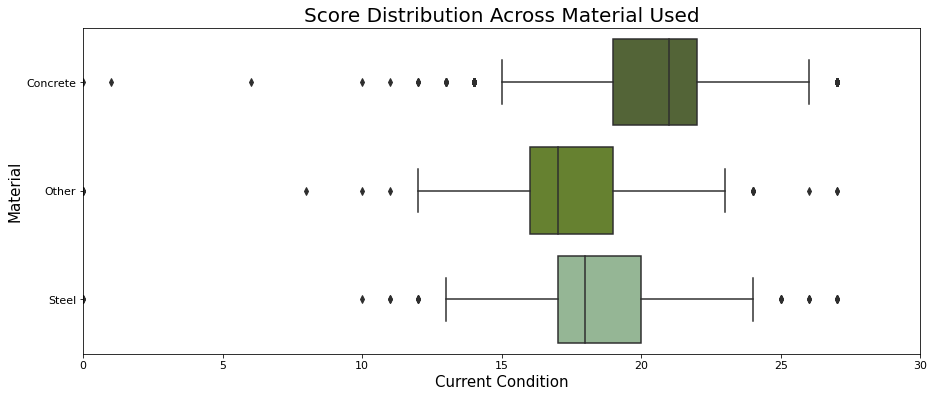

In [34]:
#plotting box plots for material, looking at their score distributions
fig, ax = plt.subplots(1, 1, figsize=(15,6))
sns.boxplot(x = df.ConditionScore, y = df.Material, ax = ax, palette = palette1)
ax.set_title('Score Distribution Across Material Used', fontsize = 20)
ax.set_xlabel('Current Condition', fontsize = 15)
ax.set_ylabel('Material', fontsize = 15)
ax.set_xlim(0,30);

#### Additional Statistics

In [35]:
#creating a materials group, then getting their Condition Score and describing to look at the mean results
material_group = df.groupby(by = 'Material', dropna = True)
material_group['ConditionScore'].describe()

,count,mean,std,min,25%,50%,75%,max
Material,,,,,,,,
Concrete,25221.0,20.261409,2.354485,0.0,19.0,21.0,22.0,27.0
Other,493.0,17.318458,3.101600,0.0,16.0,17.0,19.0,27.0
Steel,5792.0,18.163329,2.360802,0.0,17.0,18.0,20.0,27.0


From the Boxplot alongside the statistics, we can see that:
 - Generally, Concrete has the highest score of the 3 materials, as indicated by a higher overall distribution. Both median and mean of Concrete are higher than that of Steel and other. 
 - 'Other' materials seem to have a a lower overall distribution and thus, a lower overall median and average score than Steel and Concrete. 
 - Steel lies in between Concrete and 'Other' meterial categories. Steel has a higher mean score than Other but lower than concrete, same can be said about the 25th, 50th and 75th percentile.
 - There are outliers for all boxplots, meaning that all 3 sets of data for each category tail off significantly towards the ends of the scale, though all seem to have a normal and fairly symmetrical distribution.

#### 3.2.2.2 Focusing on Design

Moving onto the Design category.

Again starting off this analysis, I just wanted to show the number of bridges using each bridge design to take that into consideration when looking at the analysis. It is important to note that Beam is by far the most commonly used type of construction in bridges so keep that in mind.

In [36]:
df['Design'].value_counts()

Beam     26515
Slab      3602
Other     1389
Name: Design, dtype: int64

I have used Pie Charts to show the distribution of scores within each design below.

#### Pie Charts for Designs used showing proportion of CurrentCondition categories:

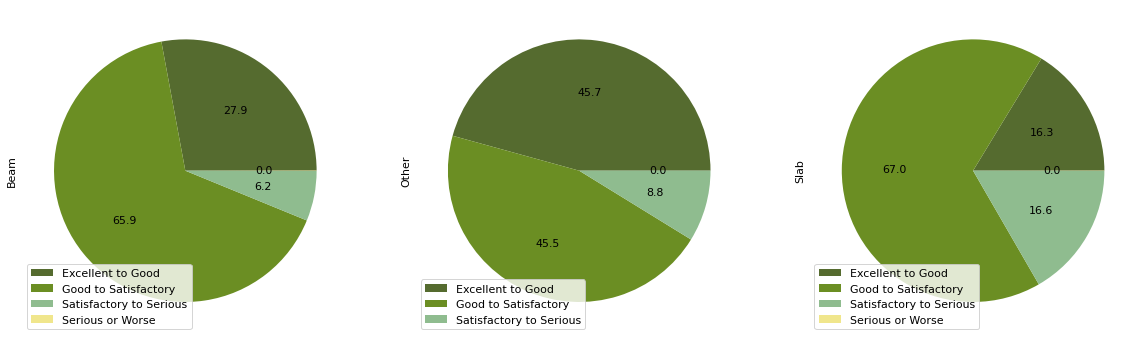

In [37]:
#again pie charts done in the same way as the Materials
cond_and_des = pd.crosstab(df.CurrentCondition, [df.Design], normalize=False)
a1,a2,a3 = cond_and_des.plot(kind='pie', subplots=True, figsize=(20,20), autopct='%.1f', colors = palette1, labeldistance = None)
a1.legend(loc = 3)
a2.legend(loc = 3)
a3.legend(loc = 3);

we can tell the following from the Pie Charts:
 - Again, all 3 design types seem generally good in terms of rating, with the least probability being 83.3% when given a material that the condition is satisfactory or greater.
 - it seems as though although Beam design has the lowest Satisfactory to serious probability, it is slightly worse overall than the 'Other' design category as the 'Excellent to Good' rating proportion in 'Other' design category is far greater (45.7% in comparison to 27.9%)
 - It seems as though slab designs are generally worse than both Beam and Other designs as they have the highest proportion of 'Satisfactory to Serious' and the smallest proportion of 'Excellent to Good' score categories.
 
Generally speaking, Other construction designs seem to be the best overall, followed by Beam designs then slab being the worst. I think this is generally due to design being more to do with engineering and technology. I would assume that as technology and knowledge advances, newer, more robust bridge designs are used which are better engineered meaning they will last longer and generally yield better results.

Below I have visualised the data, showing the probability of a Current Condition given the design of the bridge as well as the probability of the condition given the the design used.

#### Probability Bar Charts

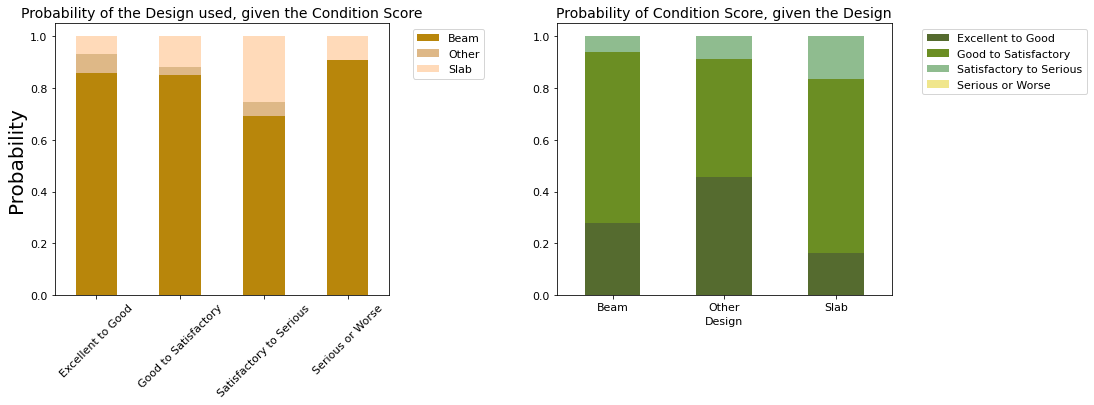

In [38]:
#conditional probabilities through cross tabulation
des_given_cond = pd.crosstab(df.CurrentCondition, [df.Design], normalize='index')
cond_given_des = pd.crosstab(df.Design, [df.CurrentCondition], normalize='index')

cond_and_des = pd.crosstab(df.CurrentCondition, [df.Design], normalize='all')
des_and_cond = pd.crosstab(df.Design, [df.CurrentCondition], normalize='all')



#plotting, same as done with the material categories
fig, (a1, a2) = plt.subplots(1, 2, figsize=(15,5))
fig.subplots_adjust(wspace=0.5)

des_given_cond.plot(kind = 'bar', subplots=False, ax = a1, rot = 45, stacked = True, color = palette2)
a1.set_title('Probability of the Design used, given the Condition Score', fontsize=14)
a1.set_xlabel('')
a1.set_ylabel('Probability', fontsize = 20)
a1.legend(bbox_to_anchor=(1.3, 1))

cond_given_des.plot(kind = 'bar', subplots = False, ax = a2, rot = 0, stacked = True, color = palette1)
a2.set_title('Probability of Condition Score, given the Design', fontsize=14)
a2.legend(bbox_to_anchor=(1.6, 1));

#### First looking at the Probability of Design used, given the Condition Score score, we can see that:
 - Again, like we saw in section 3.2.2.1, Beam seems to make up most of the probability of all the Current Conditions. This is because Beam is by far the most used Design across all bridges in Texas.
 - Despite Other being the least used, it's distribution of results across the Current Condition category is good, it indicates that it has a comparatively good 'Excellent to Good' Current Condition, which is almost equivilant of that in slab, a design category used by almost 3x as many bridges. 
 - Following on from the last point mentioned, this means that overall, Slab designs arent as great proportionally in comparison to the other two categories, and it's highest proportion of the probability lies between conditions 'Satisfactory to Serious' which is not great.
 
Now looking at the probability of the condition, given the design used, which visualises the same information as the pie charts, however, the proportions are easier to compare here between the materials. Here, it is evem clearer to see that the overall rating of 'Other' designs is better than that of both Beam and Slab. Designs which use 'Beam' seem to have the least proportion of conditions where the condition is Satisfactory or worse.

To further reinforce my analysis, a boxplot has been used to show the distribution of ConditionScore comparative to the Design used. Some additional statistical information is also provided below.

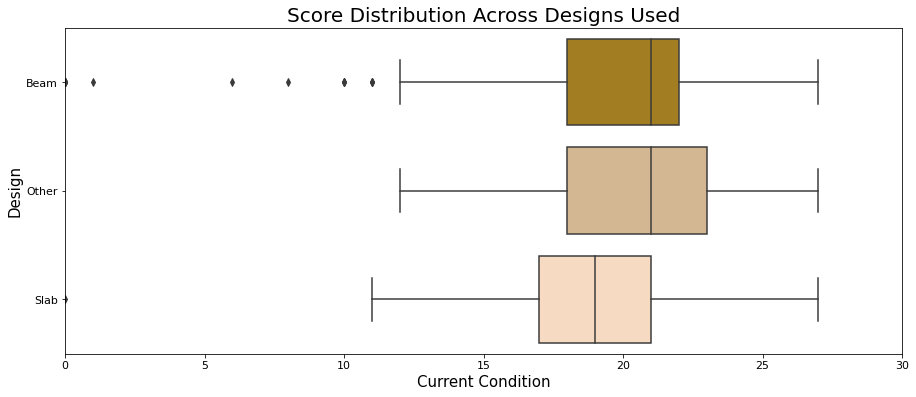

In [39]:
#box plots to show the distribution of designs against the scores
fig, ax = plt.subplots(1, 1, figsize=(15,6))
sns.boxplot(x = df.ConditionScore, y = df.Design, ax = ax, palette = palette2)
ax.set_title('Score Distribution Across Designs Used', fontsize = 20)
ax.set_xlabel('Current Condition', fontsize = 15)
ax.set_ylabel('Design', fontsize = 15)
ax.set_xlim(0,30);

#### Additional Statistics

In [40]:
#again looking at average scores for the design categories
design_group = df.groupby(by = 'Design', dropna = True)
design_group['ConditionScore'].describe()

,count,mean,std,min,25%,50%,75%,max
Design,,,,,,,,
Beam,26515.0,19.910239,2.453600,0.0,18.0,21.0,22.0,27.0
Other,1389.0,20.377250,2.890449,12.0,18.0,21.0,23.0,27.0
Slab,3602.0,19.025264,2.716683,0.0,17.0,19.0,21.0,27.0


From the Boxplot alongside the statistics, we can see that:
 - Slab seems to have the most symmetric distribution of all 3 results, however it also has the lowest mean and median values meaning that overall, it is the worst performer out of the 3 designs.
 - 'Other' designs have generally the highest mean and median values, however, it is only marginal in comparison to Beam designs. It does however, have a higher upper quartile meaning its interquartile range is generally higher and more evenly distributed in comparison to Beam's more negative skew. 
 - Beam designs seem to be the only ones with more outliers than the others, which leads me to believe that it may be an inconsistent design which works for some bridges, but not others.
 
From visualisations thus far, It seems 'Other' designs seem to yield the best results consistently, with a general pattern to follow.

### 3.3 Continuous and Categorical comparisons

This is the final part where I will be comparing the Designs and Materials used against other predictors. Starting off with some comparisons against, what I think will be the most influential predictor, Age:

#### A series of box plots comparing Design and Materials to Age:

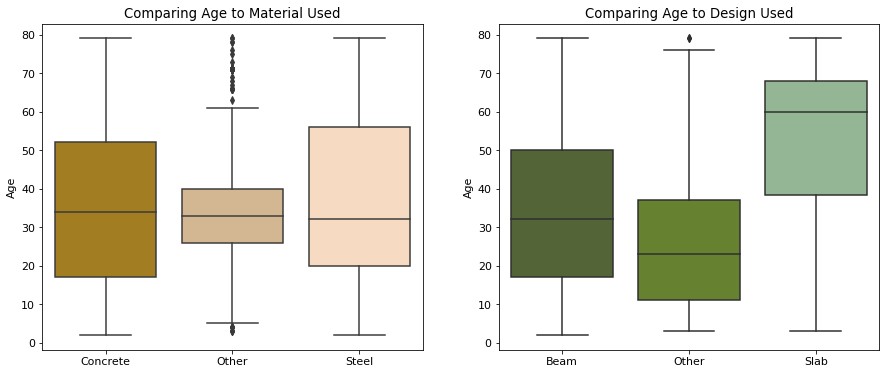

In [41]:
#boxplots comparing age to material used and design, using different colours for easier differentiation

fig, (a1, a2) = plt.subplots(1, 2, figsize=(15,6))
sns.boxplot(x = df.Material, y = df.Age, ax = a1, palette = palette2)
a1.set_ylabel('Age')
a1.set_xlabel('')
a1.set_title('Comparing Age to Material Used')

sns.boxplot(x = df.Design, y = df.Age, ax = a2, palette = palette1)
a2.set_ylabel('Age')
a2.set_xlabel('')
a2.set_title('Comparing Age to Design Used');

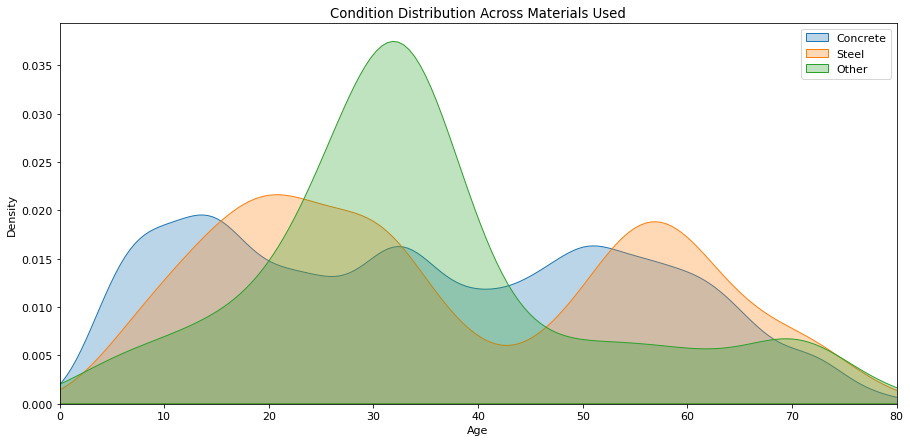

In [42]:
m_concrete = material_group.get_group('Concrete')
m_steel = material_group.get_group('Steel')
m_other = material_group.get_group('Other')

fig, ax1 = plt.subplots(1, 1, figsize=(15,7))
var = 'Age'

#kde showing distribution of materials used over time
sns.kdeplot(data=m_concrete[var], label='Concrete', ax=ax1, alpha=0.3, shade=True)
sns.kdeplot(data=m_steel[var], label='Steel', ax=ax1, alpha=0.3, shade=True)
sns.kdeplot(data=m_other[var], label='Other', ax=ax1, alpha=0.3, shade=True)


ax1.legend()
ax1.set_title('Condition Distribution Across Materials Used')
ax1.set_xlabel('Age')
ax1.set_xlim(0,80);

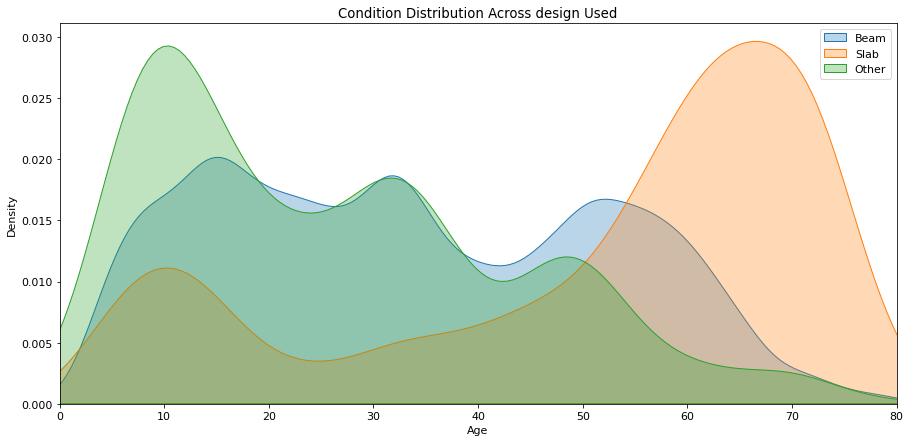

In [43]:
d_beam = design_group.get_group('Beam')
d_slab = design_group.get_group('Slab')
d_other = design_group.get_group('Other')

fig, ax1 = plt.subplots(1, 1, figsize=(15,7))
var = 'Age'

#kde showing distribution of designs used over time
sns.kdeplot(data=d_beam[var], label='Beam', ax=ax1, alpha=0.3, shade=True)
sns.kdeplot(data=d_slab[var], label='Slab', ax=ax1, alpha=0.3, shade=True)
sns.kdeplot(data=d_other[var], label='Other', ax=ax1, alpha=0.3, shade=True)

#labels and formatting, x limit is always adjusted to avoid confusion and only show whats important
ax1.legend()
ax1.set_title('Condition Distribution Across design Used')
ax1.set_xlabel('Age')
ax1.set_xlim(0,80);

#### Starting off with the observations from Material against Age:
 - There isnt much to say about this comparison, all materials seem to have a similar distribution with similar medians.
 - 'Other' materials indicates a lot of outliers in the boxplot and it clear why when looking at the box plot in conjunction with the KDE. It seems to have the tightest interquartile range which is apparent in the KDE as 'Other' materials definitely had a moment around 32 years ago it seems. This may indicate a phase where Texas was trying different materials to constructuct bridges across the state, maybe it didnt work out as well as they'd hoped which is why they reverted back to using Concrete and Steel bridges. This also explains the outliers found in the 'Other' materials category as the data tails off on either end.
 - Both Concrete and Steel bridges seem to have a similar distribution meaning that over time, both materials were equally and evenly used.
 
#### Now observing Age against the Design used:
 - We can tell there is quite a positive relationship between these two predictors. It seems as though Slab construction (Design) is quite an old technique with a negative skew meaning the older a bridge is, the more likely it is to be utilising Slab construction. This is further supported when looking at the interquartile range where the distribution clearly indicates it is generally older than both Beam and 'Other' designs. From the KDE plot, we can tell that most bridges that were built over 55 years aho were made using Slab designs.
 - There are no outliers for Slab designs, meaning that although it is an old design, it is still used a fair amount to this day desipite have having a long tail.
 - Beam has a median value of around 32 years, falling between both the Other category and the slab category, the range seems to be similar to the one found in slab. Beam has the most normal distribution where the tail lengths are comparable and the median isnt overly skewed to either side.
 - Other designs seem to be used more and more as of recently. This can be justified as designs continue to improve over time with better engineering etc. it also seems to have a long tail as well as a few outliers on the end at around 80 years. This means that throughout time, other designs were tested, but only as of recently have they started to pick up in popularity.
 
To continue my exploration, I will be comparing both categorical predictors(Material and Design) against eachother using bar charts and given probabilities.
#### Comparing Design and Material through probability

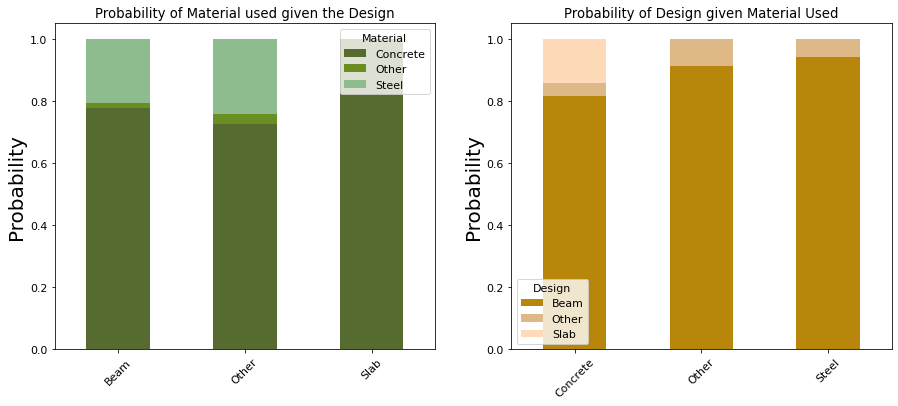

In [44]:
mat_given_des = pd.crosstab(df.Design, [df.Material], normalize = 'index')
des_given_mat = pd.crosstab(df.Material, [df.Design], normalize = 'index')

fig, (a1, a2) = plt.subplots(1, 2, figsize=(15,6))

#more probability, this time comparing designs and materials rather than material/design with score
mat_given_des.plot(kind = 'bar', subplots=False, ax = a1, rot = 45, stacked = True, color = palette1)
a1.set_ylabel('Probability', fontsize = 20)
a1.set_xlabel('')
a1.set_title('Probability of Material used given the Design')

des_given_mat.plot(kind = 'bar', subplots=False, ax = a2, rot = 45, stacked = True, color = palette2)
a2.set_ylabel('Probability', fontsize = 20)
a2.set_xlabel('')
a2.set_title('Probability of Design given Material Used');

#### Contingency Table, showing each design given the material used.
the index is normalised, meaning each row adds up to a probability of 1 (100%)

In [45]:
#looking at the probability a design is used given the material, slab is used exclusively by concrete
des_given_mat = pd.crosstab(df.Material, [df.Design], normalize = 'index')
des_given_mat

Design,Beam,Other,Slab
Material,,,
Concrete,0.817216,0.039967,0.142817
Other,0.910751,0.089249,0.000000
Steel,0.941816,0.058184,0.000000


Above are comparisons of given probability.

Observing the probability of Material used given the design, we can say:
 - Concrete is used most commonly in all designs, with steel being the second most popular material and Other making a very small proportion of 'Other' and 'Beam' designs.
 - Slab design only uses Concrete as a construction material, which must mean that slab is a design which requires concrete to be built. 
 
Observing the probability of Design given Material used, we can say:
 - When looking at Other materials, They are used explicitly in Beam and 'Other' designs.
 - Beam is the most popular design amonst all materials, making up a probability of 0.8. This means that given any bridge in Texas made of any of the 3 categories of materials here, there is a chance greater than 80% that the bridhge chosen utilises 'Beam' design.
 
Comparing our findings to the contingency table, we can see that Beam designs are by far the most popular amongst all 3 Materials. 

## 3.4 Preliminary Conclusions

in this section, most combinations of comparisons were made between the Predictor variables against each other as well as all predictor variables against the target variable. my preliminary conclusions lead me to believe that:
 - Firstly, Age will have the biggest influence on the target variable (Condition) which is exactly what I would expect. As a bridge gets older, it is more prone to corroding, freeze-thaw weathering, cracking due to heat and moisture etc. No bridge will be able to last forever.
 - Secondly, and to my surprise, Concrete seems to also have a noticeable impact on the durability of a bridge. Concrete as a material seems to have generally the highest scores of the 3 material categories. It is also most commonly used around Texas as the primary construction material. 
 - Thirdly, Other designs from the 'Design' predictor may also show some noticeable impact as though there is little data available, the data that is proves that the designs are better than the more generic 'Beam' and 'Slab' designs. 'Other' designs seem to also correlate positively with the age variable, as 'Other' designs seem to have gained popularity, possibly due to their durability and good condition ratings.
 - Fourth, other predictors not mentioned here will have little to no impact on the target variable, as there was no obvious correlation present. Usage, whether it be by 'DailyAverage' or the proportion of truck usage doesn't seem to have a great impact on the strength or condition of the bridge.

# 4. Regression

This is the final section of this document. which will have a main focus on identifying approximately how influential each of the predictor variables are against the target variable. We will start off by preparing the data through normalising distributions, then sorting categorical data and turning them into dummy variables. Improving / adjusting data here is crutial in order to obtain an accurate result from the regression model.
## 4.1 Preparing the Data

#### Firslty looking at the current distributions of the Predictor variables:

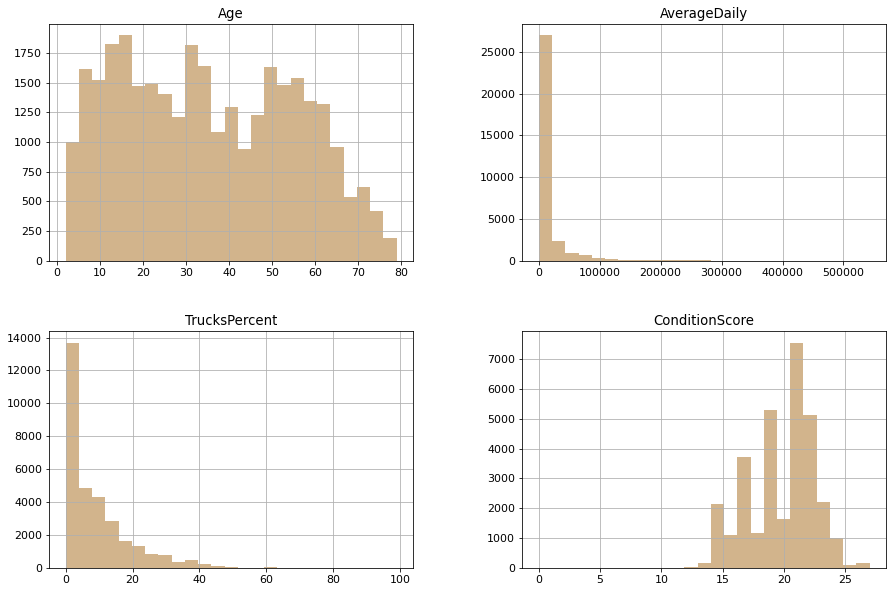

In [46]:
#plotting histograms for all numeric-based predictors
df.hist(figsize = (15,10), color = 'tan', bins = 25);

As we can tell from the histograms displayed above, the `Age` variable and the `ConditionScore` variables seem to be okay. However, `AverageDaily` and `TrucksPercent` seem to have a very strong positive skew, with may impact the accuracy of our model.

In order to get rid of this skew, a transformation is deployed using the log function. This way we can help address the distribution issues and hopefully normalise it such that we can continue to plot our regression model. 
#### Below are the results:

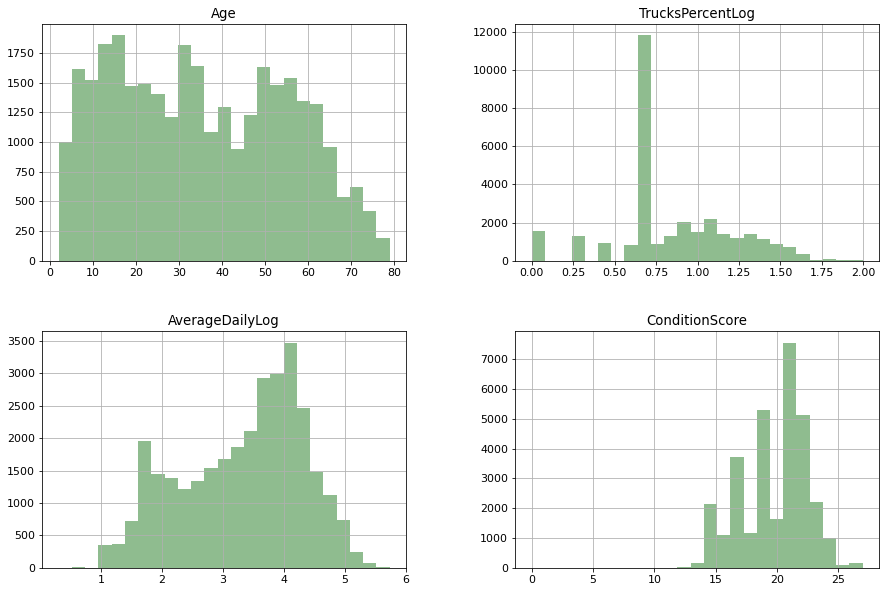

In [47]:
#using a log function to normalise average daily and trucks percent. removing the skew
df_logs = df.assign(AverageDailyLog = np.log10(df.AverageDaily),
                         TrucksPercentLog = np.log10(df.TrucksPercent))

#I got a lot of inf values, to deal with that I used the .replace() function to replace inf with more useful relevant values
df_logs['TrucksPercentLog'] = df_logs['TrucksPercentLog'].replace(np.NINF, df_logs.TrucksPercentLog.median())
#for average daily, I converted to 0, then turned the 0 into the median value
df_logs['AverageDailyLog'] = df_logs['AverageDailyLog'].replace(np.NINF, 0)
df_logs['AverageDailyLog'] = df_logs['AverageDailyLog'].replace(0, df_logs.AverageDailyLog.median())

#dropped categories that are not needed in this dataframe
df_logs.drop(['TrucksPercent', 'AverageDaily', 'CurrentCondition'], axis = 1, inplace = True)

#reordered the dataframe
df_logs = df_logs[['Age', 'Material', 'Design', 'TrucksPercentLog', 'AverageDailyLog', 'ConditionScore']]

#plotted the histograms again for the client in a different colour for easier differentiation
df_logs.hist(figsize = (15,10), color = 'darkseagreen', bins = 25);


As you can see, the results data is looking a lot better. However I did have a slight issue with infity numbers due to the log function and have chosen to approach both `AverageDailyLog` and `TrucksPercentLog` differently to deal with their skew.

starting off with `TrucksPercentLog`:
 - since this is a percentage, values near to 0 are possible and thus, after using the log function I got a huge influx of infinity numbers. However, I do believe that some, if not most of those numbers are inaccurately representing the proportion of trucks. in most cases, there will be at least some sort of value recorded for trucks passing through the bridge. however, it may be a lot harder to detect this than just simply the average daily where a camera can pick up all bypassing traffic. Thus I believe some results are misreported / Non numeric values are added with a trucks percent of 0. To address this issue, I have decided to replace all infinity values with a median score from the category, meaning those inaccuracies just fall into the middle of the dataset to remove the skew. There is a greater likely-hood that their new representation is more accurate than the one they were set to before (0 or other).
 
moving onto `AverageDailyLog`:
 - unlike `TrucksPercentLog`, the chances of the `AverageDaily` users of a bridge is 0 is next to impossible, unless a bridge is closed down which makes it an anomaly. First of all, just to make sure no numbers are set to infinity, I have replaced all Infinity values with 0. However, I know this is more than likely not true for any bridge in the dataset, so I have replaced all 0 values with the median value of the dataset. This is different to the way I handled the Trucks Percent Log in a way such that in `TrucksPercentLog`, there are still some values at 0%. however, there are no bridges with an `AverageDailyLog` of 0.

Now I will be using dummy variables, 1 of the categories has to be dropped in order to reliably use the dummy variables in the end to plot the Regression line. I will be selecting 2 of the 3 categories found in the Materials variable to analyse. based on section 3, I believe it would be most suitable to choose Concrete and Steel as the materials in this scenario as our previous analysis shows that they both seem to have more of an impact on the target variable than the 'Other' materials.

#### Print out of the dummy variables for materials

In [48]:
#creating material dummy variables
mat_d = pd.Categorical(df.Material, 
                      categories=['Other', 'Concrete', 'Steel'],
                      ordered=True)

material_d = pd.get_dummies(mat_d, drop_first=True)
material_d

,Concrete,Steel
0,1,0
1,1,0
2,1,0
3,0,0
4,1,0
...,...,...
31501,1,0
31502,1,0
31503,1,0
31504,1,0


As you can see, rather than having 1 variable representing 3 different categories, we have used dummy variables to split up the materials into their own columns (variables), This way we can assign numeric values to them, 1 and 0. Where 1 means that the material is used, and 0 means it is not. If neither categories are assigned a value, the dummy function defaults to 'other' being the material used.

Example:
 - Looking at the printed table, if we look at the 3rd row, indexed by the value of 2, we can see that this particular bridge uses Concrete.
 
Now following the same procedure for the Design categories, from our data exploration section I found that Beam designs as well as 'Other' designs seemed to have the best performance against the condition, so those two categories will be selected and Slab will be dropped.

#### Print out of the dummy variables for Design

In [49]:
#creating design dummy variables
des_d = pd.Categorical(df.Design, 
                      categories=['Slab', 'Beam', 'Other'],
                      ordered=True)

design_d = pd.get_dummies(des_d, drop_first=True)
design_d

,Beam,Other
0,0,0
1,0,0
2,1,0
3,1,0
4,1,0
...,...,...
31501,1,0
31502,1,0
31503,1,0
31504,1,0


Now that we have set up our categorical data appropriately, we can move on to find our coefficients and plot our line of regression.

## 4.2 Regression Modelling

### 4.2.1 Analysing Coefficients

First of all, we set Y to be our target variable, in this case the Condition Score (Measured in marks between 0 - 27). We then create a new table consisting of our Predictor variables(Age, AverageDaily, TrucksPercent, Material and Design). 

#### below is a print out of the first 5 rows:

In [50]:
#creating the y and x values from the dataframes available. x is our predictor, y is our target
y = df.ConditionScore
X = np.column_stack((df_logs.Age, df_logs.AverageDailyLog, df_logs.TrucksPercentLog, design_d.Beam, design_d.Other, material_d.Concrete, material_d.Steel))

#printing a preview for the client
X[0:5].astype(int)

array([[16,  3,  0,  0,  0,  1,  0],
       [16,  3,  0,  0,  0,  1,  0],
       [ 9,  2,  0,  1,  0,  1,  0],
       [71,  1,  0,  1,  0,  0,  0],
       [17,  2,  0,  1,  0,  1,  0]])

Now that we have our dataset successfully sorted into co-ordinates of X and Y values, we can now look at fitting a regression model and intially, looking at the R2 coefficient of determination and the intercept, below are the results:

In [51]:
#fitting a linear regression through the predictors and target
reg = LinearRegression().fit(X, y)

#displaying R2 coefficient
print('The R2 coefficient of determination is:\t %4.3f' % reg.score(X, y))
print('\nThe intercept is:\t\t\t %4.1f' % reg.intercept_)

#storing beta values for later use
beta_Age, beta_AverageDaily, beta_TrucksPercent, \
beta_DesignBeam, beta_DesignOther, beta_MaterialConcrete, \
beta_MaterialSteel = reg.coef_

The R2 coefficient of determination is:	 0.444

The intercept is:			 19.6


#### What is the R2 coefficient of determination?

The R2 is the square of the correlation (R-squared). It measures the proportion of variation in the dependent variable that can be attributed to the independent variable. The R2 value typically lies between 0 and 1, and is a measure of how close the data points are to our linear regression line, basically indicating the strength of corrolation. The higher the R2, the higher the correlation between the predictors and target variable.

#### What does it tell us?
 - In this case, the R2 value here tells us that there is moderate correlation between our predictor variables and the target variable, however, it is not extremely strong nor extremely weak. 
 - There is some variance in the dataset, which leads to the model not being extremely accurate. Though this is the case, we could still say that to some degree, there is a moderate relationship between the predictors and target variable.
 
#### What is the intercept value?
The intercept value is derived from the intercept at which our regression line meets the y axis, thus the Y intercept tells us the predicted value of the mean of X when x = 0.

#### What does the intercept value tell us?
 - With the mean value of x (our predictors) being rather high at 19.6, it means our predictors generally average a good score. The gradient / coefficients thus cannot be that high as the maximum score is out of 27.
 
#### Values of Estimated Regression Coefficients for each predictor

In [52]:
#printing beta values for the client to see

print('Estimated regression coefficient for Age:\t\t %.6f' % beta_Age)

print('\nEstimated regression coefficient for Average Daily:\t %.6f' % beta_AverageDaily)

print('\nEstimated regression coefficient for Trucks Percent:\t %.6f' % beta_TrucksPercent)

print('\nEstimated regression coefficient for Design-Beam:\t %.6f' % beta_DesignBeam)

print('\nEstimated regression coefficient for Design-Other:\t %.6f' % beta_DesignOther)

print('\nEstimated regression coefficient for Material-Concrete:\t %.6f' % beta_MaterialConcrete)

print('\nEstimated regression coefficient for Material-Steel:\t %.6f' % beta_MaterialSteel)

Estimated regression coefficient for Age:		 -0.072969

Estimated regression coefficient for Average Daily:	 0.041916

Estimated regression coefficient for Trucks Percent:	 0.144763

Estimated regression coefficient for Design-Beam:	 0.055091

Estimated regression coefficient for Design-Other:	 0.153247

Estimated regression coefficient for Material-Concrete:	 2.868156

Estimated regression coefficient for Material-Steel:	 0.941189


Above is a set of Estimated Regression Coefficients for all values. Since the values have not been standardised they are all operating on different scales, and thus all values indicate a different level of impact on the target variable regardless of the number displayed.

For Example:
I would expect that comparatively, Age would have a larger impact than other predictors like materials or even designs, and as we see later on in this document that is the case. However, since nothing here has been standardised they work on different scales, making Age seem insignificant in terms of target variable influence. 

In order to compare the coefficients appropriately, we need to do a calculation which essentially unifies the scales. One way of doing this would be looking at the range of each of the Predictors as a percentage over the range of the condition.

#### Below are the ranges of the predictors and the condition (target variable)

In [53]:
#keeping the client engaged and giving her a look at what goes on behind the scenes for the calculations, transparancy with client

age_range = df.Age.quantile(0.90) - df.Age.quantile(0.1)
averageDaily_range = df_logs.AverageDailyLog.quantile(0.9) - df_logs.AverageDailyLog.quantile(0.1)
trucksPercent_range = df_logs.TrucksPercentLog.quantile(0.9) - df_logs.TrucksPercentLog.quantile(0.1)
condition_range = df.ConditionScore.quantile(0.9) - df.ConditionScore.quantile(0.1)

print('Age range (10th to 90th centile) is:\t\t\t %3.f' % age_range, 'years')

print('\nCondition range (10th to 90th centile) is:\t\t %3.f' % condition_range, 'marks')

Age range (10th to 90th centile) is:			  52 years

Condition range (10th to 90th centile) is:		   7 marks


Above are the presentable ranges. Both Age and Condition are presented. Note that we did not observe the range of categorical variables, nor the variables in whic a log function was applied to. The range of categorical data will be either a 1 or a 0 due to the dummy function, and the range of both the AverageDailyLog and the TrucksPercentLog will not make much sense in log form so I have decided to leave them out of the print function. However, they are still calculated in the background.

Now that we have the range of the predictors and the range of the target variable, We can calculate the change in the target values as a percentage of its range that would result from the changing each of the predictor variables over its range. This gives a better comparison of the importance of the predictors.

For this calculation, I will assume a range of 1 for all categories which represents their on state. this allows us to look at the impact it has on the target values as a percentage without getting a returned value of 0.

#### Comparing the importance of predictors:

In [54]:
#printing out the percentages formatted, to show the client the relationship between predictors and target

print ('\nThe change in Condition given by the Age coefficient (over its range) is:\t\t %4.2f'
       % (100 * (beta_Age * age_range) / condition_range) + '\t%')

print ('\nThe change in Condition given by the Average Daily coefficient (over its range) is:\t %4.2f'
       % (100 * (beta_AverageDaily * averageDaily_range) / condition_range) + '\t%')

print ('\nThe change in Condition given by the Trucks Percent coefficient (over its range) is:\t %4.2f'
       % (100 * (beta_TrucksPercent * trucksPercent_range) / condition_range) + '\t%')

#1 range assumed for all categorical variables, so that they return an output other than 0
print ('\nThe change in Condition given by the Beam Design coefficient is:\t\t\t %4.2f'
       % (100 * (beta_DesignBeam * 1) / condition_range) + '\t%')

print ('\nThe change in Condition given by the Other Design coefficient is:\t\t\t %4.2f'
       % (100 * (beta_DesignOther * 1) / condition_range) + '\t%')

print ('\nThe change in Condition given by the Concrete Material coefficient is:\t\t\t %4.2f'
       % (100 * (beta_MaterialConcrete * 1) / condition_range) + '\t%')

print ('\nThe change in Condition given by the Steel Material coefficient is:\t\t\t %4.2f'
       % (100 * (beta_MaterialSteel * 1) / condition_range) + '\t%')


The change in Condition given by the Age coefficient (over its range) is:		 -54.21	%

The change in Condition given by the Average Daily coefficient (over its range) is:	 1.62	%

The change in Condition given by the Trucks Percent coefficient (over its range) is:	 1.83	%

The change in Condition given by the Beam Design coefficient is:			 0.79	%

The change in Condition given by the Other Design coefficient is:			 2.19	%

The change in Condition given by the Concrete Material coefficient is:			 40.97	%

The change in Condition given by the Steel Material coefficient is:			 13.45	%


#### How do we interpret this?

A negative percentage means that this particular predictor affects the target variable, in our case the condition, negatively meaning the more there is of that predictor, or the greater the value of it is, the more likely it is for the condition to get worse. A positive percentage indicates a positive correlation between the Predictor and the Target variable, meaning that the greater the value of the predictor, or the more of it there is, the higher the target variable will get. In our case, this is good as it means the condition gets better.

#### Taking this into consideration, we can now assess the coefficients:

 - `Age` : Age seems to have the strongest influence at -54.21%. This indicates that as the value of Age gets higher (Older), the more likely it is for the bridge to worsen in condition. From this we can say the older the bridge, the worse the overall condition of the bridge gets. This percentage is quite high meaning there is strong correlation between the `Age` variable and the `ConditionScore` target variable.
 
 - `AverageDaily` : At 1.62%, we could confidently say that this variable has little to no impact on the Condition Score. however, the percentage is slightly positive so technically, it would mean that the more `AverageDaily` users there are, the better the condition becomes. This doesnt make much sense, however accuracy issues are to be expected when working with a simple linear regression model as it is bound to underfit.
 
 - `TrucksPercent` : It seems as though the proportion of trucks using the bridge also seems to impact the condition positively (1.83%). which means that the higher proportion of truck users, the more likely a bridge is in better condition. I guess this could be justified by saying that generally, truck users would avoid bridges which are in bad condition as their weight / load may worry them when crossing a bridge in serious or worse conditions.
 
 - `Beam` Design : Beam design seems to also positively impact the target variable, however only at 0.79% which is a very insignificant amount. This indicates that `Beam` design bridges generally dont affect the the overall condition of a bridge.
 
 - `Other` Design : Other designs also seem to be good, positively impacting the `ConditionScore` target variable of a bridge by 2.19%. Though this is not a great deal, it does fall in line with analysis undertaken in section 3, where we found that `Other` designs seemed to be the best overall designs to use in bridges.
 
 - `Concrete` Material : This was a rather surprising amount (40.97%), but it seems like using `Concrete` as a material seems to have a huge positiveimpact on the `ConditionScore` variable, being the second biggest influencer on our target. This may be because of how widely used it is in Texas, as section 3 findings indicate that most bridges built in texas use `Concrete` as the building material. It also scored the highest of the 3 materials in terms of `CurrentCondition` and `ConditionScore` averages.
 
 - `Steel` Material: Finally Steel, which we found in section 3 to also be a relatively good material, however Concrete was overall better. This is reflected in these results with `Steel` only affecting the target variable by 13.45% in comparison to `Concrete`'s 40.97%. However, conclusively we could say that both `Concrete` and `Steel` positively impact the `ConditionScore` variable. i.e. when present, the general condition of a bridge is usually higher.
 
 
### 4.2.2  Analysing the Error Distribution and the RMSE value

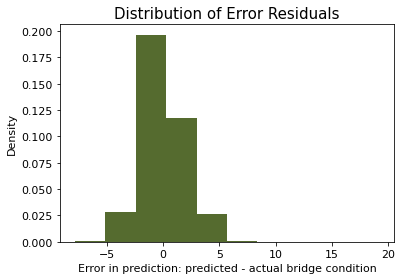

In [55]:
#obtaining yhat value
y_hat = reg.predict(X)
fig, a1 = plt.subplots(1, 1)
residuals = y_hat - y
#plotting distribution of residuals
a1.hist(residuals, bins=10, density=True, color = 'darkolivegreen')
a1.set_xlabel('Error in prediction: predicted - actual bridge condition')
a1.set_ylabel('Density')
a1.set_title('Distribution of Error Residuals', fontsize = 15);

From this Distribution of Errors, it seems as though we have a relatively symmetrical distribution of residuals, meaning that our model is effective in detecting the underlying pattern. If this distribution were to be skewed it would mean that the independent variabes we have chosen to predict the target variable are not representative and are not effective enough. The distribution tells us that we have selected an appropriate model and our data is indicative of a pattern. The data, though symmetric around 0, seems to have a slight positive skew. However, this is understandable considering our data preparation in section 4.1 where the histograms indicated that our target variable was also skewed.

#### Looking at the RMSE value:

In [56]:
# The mean squared error
print('Root of the mean squared error: %.2f'% mean_squared_error(y, y_hat, squared=False))

Root of the mean squared error: 1.88


Above is the RMSE value of the model. This numeric value is a measure for how accurately or model represents the data. it represents the mean squared distance of the datapoints from our line of regression. This model seems to be okay. It is not the most accurate, which again is to be expected considering it is a simple linear regression line, which does not articulate towards data trends in specific areas, but rather a general fit for the whole dataset. Nonetheless, 1.88 is not a bad value for RMSE. Of course, with a simple linear regression, there is no risk of overfitting (where RMSE = 0) as the line does not bend or conform to the data, rather is just plotted down the middle of the dataset. 

### 4.2.3 Using Regression to analyse the accuracy of the model

In this section, I have plotted a our regression model, comparing the predicted values against the actual value our model has predicted. I have chosen to plot 2 variants of this same regression line, which focus on 2 different aspects of our findings.

#### Regression Plots

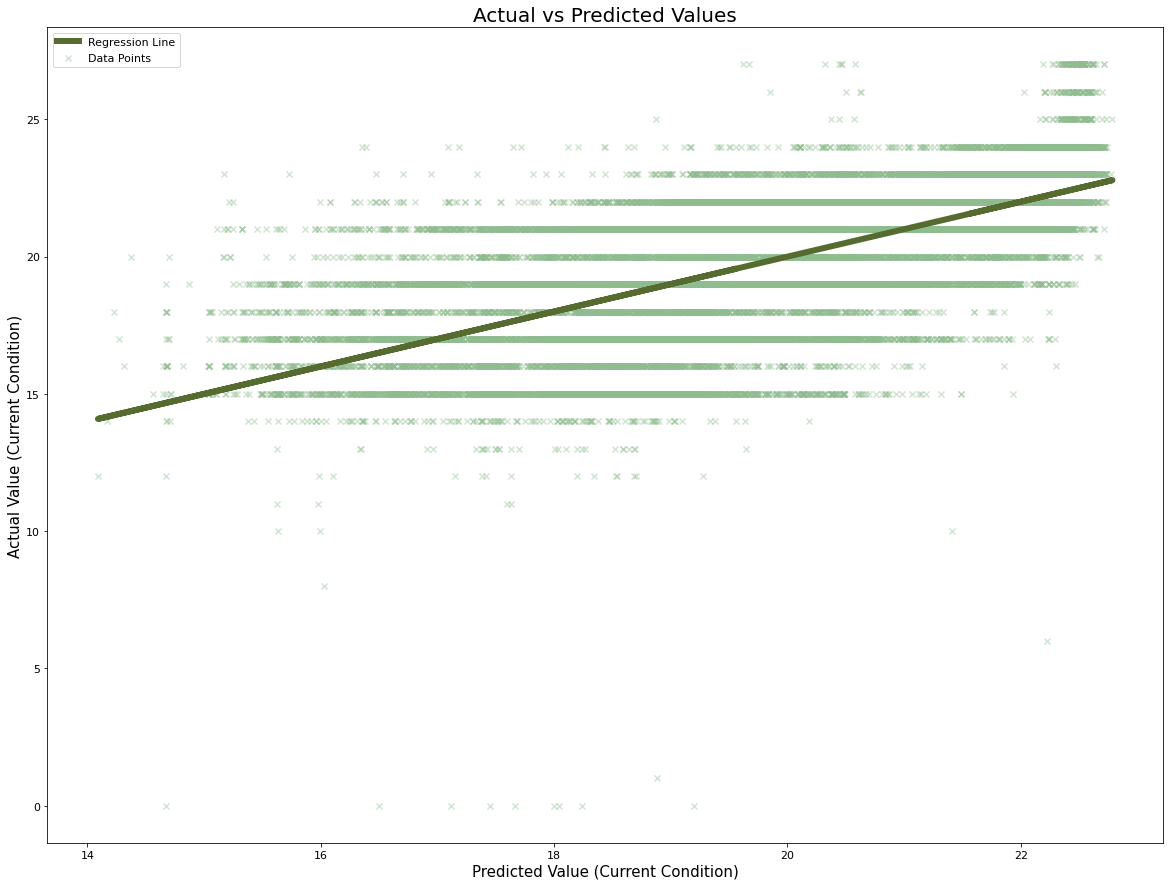

In [57]:
# Plot outputs
fig, a = plt.subplots(1,1,figsize=(20,15))
a.scatter(y_hat, y,  color='darkseagreen', alpha = 0.4,  marker='x', label = 'Data Points')
a.plot(y_hat, y_hat, color='darkolivegreen', linewidth=6, label = 'Regression Line')

#Formatting
a.set_xlabel('Predicted Value (Current Condition)', fontsize = 15)
a.set_ylabel('Actual Value (Current Condition)', fontsize = 15);
a.set_title('Actual vs Predicted Values', fontsize = 20)
a.legend();

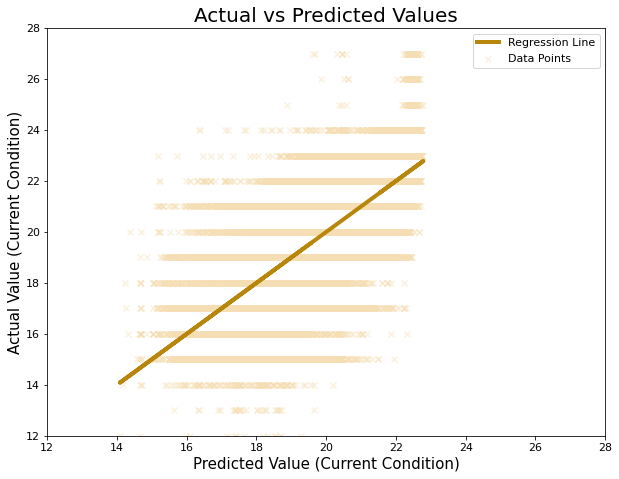

In [58]:
#Plot outputs
fig, a = plt.subplots(1,1,figsize=(10,7.5))
a.scatter(y_hat, y,  color='wheat', alpha = 0.4,  marker='x', label = 'Data Points')
a.plot(y_hat, y_hat, color='darkgoldenrod', linewidth=4, label = 'Regression Line')

#Formatting
a.set_xlabel('Predicted Value (Current Condition)', fontsize = 15)
a.set_ylabel('Actual Value (Current Condition)', fontsize = 15);
a.set_title('Actual vs Predicted Values', fontsize = 20)
a.set_xlim(12,28)
a.set_ylim(12,28)
a.legend();

Starting off by analysing the green regression plot:
 - It seems as though there was a high variance in the dataset, but all correlated well which meant that our regression line did not perform too badly. if the variation was high, and the trends changed as the score went up it would have created a bigger issue.
 - There are anomalies, which we can vaguely see at the bottom of the plot. Since our model is linear, these datapoints were fortunately not taken into consideration and did not impact our linear model's overall accuracy it seems.
 - There was a tail at the higher end of the scores, which can be seen from the actual values recorded, where our model was not accurate in predicting. Again, due to its linear form, it did not conform or take to the shape of the data too well. however, we can see that at the end of our model, where it predicted 23 as a score, there were numerous results which were considerably higher at 25, 26 and even 27. Since distribution was fairly high and some bridges scored considerably lower, the slope of the line (R2 Coefficient) was not impacted too much or skewed to the extreme ends of the dataset.
 
Now looking at the second plot in brown:
 - This plot represents the same data and uses the same regression line, however the point of this is to even out the scale such the accuracy of the model is seen better. As you can see, the ticks at both the X axis and the Y axis are of the same amount and the same values. Ideally, now when looking at the regression and since it is linear, the line is pretty much at y = x. We can again, look at the predicted values and tell they fall short of the true results.
 
# 5 Conclusion

Taking into consideration that you are a metal Corrosion / Concrete deterioration specialist, I have focused a lot on those materials and how they impact the condition of the bridge, So I will start my conclusive analysis with a detailed overview of material use, then move on to the other predictors and their impact:
 - Material
     - From my analysis, I found both materials to have a similar distribution over Age (Time), which means that through the years, they have both been used for the construction of bridges. Concrete was generally a more popular option; they were both relatively in use across all years. from my understanding, Concrete seemed to generally perform better over time. This is because generally bridges that were made of concrete were found in better condition, no matter the period of time they were built in, in comparison to Steel bridges. A higher proportion of Concrete bridges were found between Satisfactory to Excellent condition, as well as a higher proportion in Good to Excellent conditions exclusively. I have made sure that the numbers did not impact this analysis by using these figures as percentages / probability. Which means that they are treated as individual variables. Other materials used seemed to generally perform worse however, which leads me to believe that both Concrete and Steel are the best options going forward. 
  
     - These findings were especially reflected in section 4 of this document, where Concrete seemed to have more of an impact on the rate of target variable change (40.97% effectiveness via Concrete in contrast to 13.45% with Steel). However, in these findings, I cannot tell for certain whether this impact takes into account the number of bridges using each of the material. Because if that is the case, then these numbers are accurate, if not then I would expect the percentage provided for Concrete to be lower and a lot closer to the percentage of change associated with Steel.
     
 - Age:
     - I think this predictor was one which was fairly obvious, however the level of impact was uncertain. We knew going in that age would be the variable most influential on the Condition of a bridge. As with anything over time, a material or structure will eventually deteriorate, nothing can maintain its original condition forever. That said, my findings show that its impact influenced the target variable by a change rate of -54.21 which, in contrast to concrete, is not what I had originally anticipated. I would have thought it would make a bigger difference in comparison to any of the other predictors used for this model. Which leads me to believe that either the concrete figure is inaccurate, or concrete is extremely good at retaining a bridge's condition. My take on it is that this linear model is too simple to pick up enough detail from the predictors, leading to a model which may be inaccurate and misleading in some respects, however good for a general idea of what is going on.     


 - AverageDaily and TrucksPercent:
     - The results obtained from average daily and trucks percent were not what I particularly expected. This may be due to the skew that was originally on the data, or lack of accurately recorded data. Overall, I did not expect either variable to have a positive impact on the target variable. I would have assumed that increased usage of a bridge, or increased load due to truck weight would accelerate the deterioration rate of a bridge. Since both are relatively marginal impacts, I think it would be fair to assume that further testing and modelling would be required before coming to a final decision on the impact they have on the Target variable, as simple linear models tend to underfit data so these may be inaccurately represented in our model.
     
 - Design
     - This is another area which took me by surprise, as I thought the choice of design would affect the durability of a bridge. Coming from an Architectural background, I have realised that engineering and good design goes a long way, especially in the built environment. My findings indicated that Other designs seem to be used more recently than Beam and Slab designs, which was to my expectation as newer designs and techniques are used with the aid of technology, which allows for better risk assessment and more data and research going into newer types of designs. This proved to be true right until the end where the model returned a change rate percentage of only 2.19%. Though this is a higher score than Beam design's 0.79%, I would have expected more. Again, these two categories were not frequently used in comparison to Slab design, which may be the issue. 
     
Conclusively, I believe the model is good for painting the general picture, but poor at picking up the finer details in the dataset. It seems to not take consideration into proportion, but rather the number of results. leading me to believe the model is partially inaccurate, especially when looking at the smaller sets within the data. This is why it was important to reduce the number of categories when looking at both Materials and Design. This was expected due to how simple linear regression is and how little it conforms to data; however, the model seems to pick up the more obvious trends in the data, whilst misinterpreting the little ones. This is because it is impossible for a regression line to overfit or get close to data with a relatively high variance. As we saw from the final regression plots, there was relative variance in the data as well as a slight tail towards the higher end of the scores which may be causing issues.

In order to improve this model, a non-linear regression line should be used to estimate the result. It would be important to also consider other predictors to compare against the condition (target variable). these could include:
 - Location of the bridge: whether the bridge is near a lake or an area where moisture levels are high. This could negatively impact bridge conditions, especially ones made out of Steel as it could cause the bridge to rust at a faster rate than say, a bridge located in an urban area away from moist conditions.
 - The size of the bridge: small bridges may be easier to maintain and may last longer as they do not need to span over large distances, whereas a large bridge may be prone to more usage and will be constantly under more strain than a smaller bridge due to the weight of the material itself and the construction. I think this particular variable could be associated well with the design used as well as the material used. Material could indicate how well it fairs with weight, or even how light it is whereas design could tell us more about what the best design is to maintain the bridges condition over time.
